In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from astropy.cosmology import WMAP9 as cosmo
from scipy.integrate import quad
#from astropy.cosmology import Planck15   # You can choose a different cosmology if needed
import astropy.units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
from numba import jit
from glob import glob
import pandas as pd
from scipy.stats import gaussian_kde
from tqdm import tqdm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


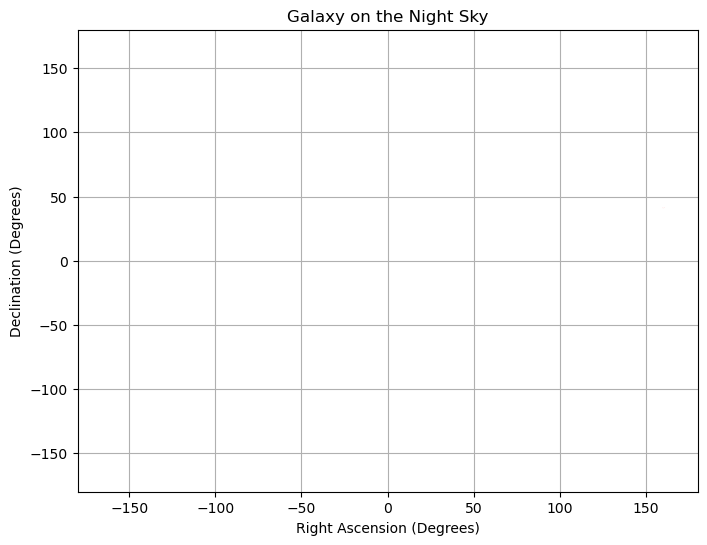

In [3]:


def plot_galaxy(ra, dec, angular_size_mas, orientation_deg):
    # Convert RA and Dec to degrees for plotting (assuming RA is given in hours)
    ra_deg = ra * 15  # 1 hour = 15 degrees
    dec_deg = dec
    
    # Convert angular size from mas to degrees
    angular_size_deg = angular_size_mas / 1000 / 3600
    
    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plotting the galaxy as an ellipse
    galaxy_ellipse = Ellipse((ra_deg, dec_deg), width=angular_size_deg, height=angular_size_deg/2, angle=orientation_deg, edgecolor='red', facecolor='none')
    
    ax.add_patch(galaxy_ellipse)
    
    # Setting labels and title
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Galaxy on the Night Sky')
    plt.grid(True)
    
    # Set limits for better visibility, assuming we're focusing on a small area of the sky
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    
    plt.show()

# Example values for a galaxy
ra_example = 10.684  # Right Ascension in hours
dec_example = 41.269  # Declination in degrees
angular_size_mas = 13000 # Angular size in milliarcseconds

orientation_deg_example = 45  # Orientation in degrees

# Plot the galaxy
plot_galaxy(ra_example, dec_example, angular_size_mas, orientation_deg_example)


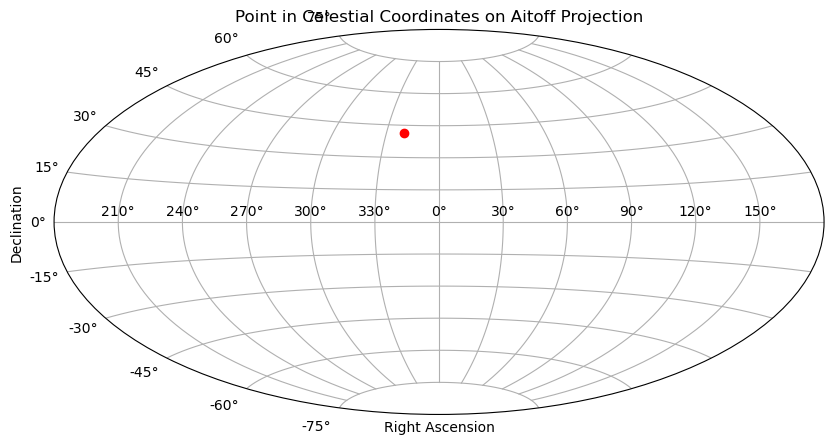

In [4]:
def plot_celestial_point_aitoff(ra_hours, dec_degrees):
    # Convert Right Ascension from hours to radians for the Aitoff projection
    # RA is adjusted by subtracting 12 hours to center the plot, then converted to radians
    ra_radians = np.radians((ra_hours - 12) * 15)
    
    # Convert Declination from degrees to radians
    dec_radians = np.radians(dec_degrees)
    
    # Set up the plot with Aitoff projection
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='aitoff')
    
    # Plot the point
    ax.plot(ra_radians, dec_radians, 'ro')  # 'ro' plots a red dot
    
    # Setting grid and labels
    ax.grid(True)
    plt.title('Point in Celestial Coordinates on Aitoff Projection')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)
    
    # Adjust the tick labels for RA and Dec to be more readable
    ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°', '90°', '120°', '150°'])
    #ax.set_yticklabels(['-60°', '-30°', '0°', '30°', '60°'])
    
    plt.show()

# Example values for RA and Dec
ra_example = 10.684  # RA in hours
dec_example = 41.269  # Dec in degrees

# Plot the point on the celestial map with an Aitoff projection
plot_celestial_point_aitoff(ra_example, dec_example)

In [5]:
cso_galaxies ={

  
    "J0000+4054": {"R.A.": "00:00:53.08", "Dec.": "+40:54:01.81", "z": 'nan', 'Ang_size': '124.0', 'lin_size': 'nan', 'Turnover_freq': '0.323', 'Turnover_flux_den': '2.06','class':'nan'},
    "J0003+4807": {"R.A.": "00:03:46.04", "Dec.": "+48:07:04.14", "z": 'nan', 'Ang_size': '16.2', 'lin_size': '0.139', 'Turnover_freq': '2.123', 'Turnover_flux_den': '0.348','class':'nan'},
    "J0029+3456": {"R.A.": "00:29:14.24", "Dec.": "+34:56:32.25", "z": '0.517' ,'Ang_size': '29.1', 'lin_size': '0.180', 'Turnover_freq': '0.8', 'Turnover_flux_den': '2.0','class':'2.1','major_axis_comb':'4.2'},
    "J0111+3906": {"R.A.": "01:11:37.32", "Dec.": "+39:06:28.10", "z": '0.66847', 'Ang_size': '8.0', 'lin_size': '0.056', 'Turnover_freq': '4.0', 'Turnover_flux_den': '1.33','class':'2.0','major_axis_comb':'4.0' },
    "J0119+3210": {"R.A.": "01:19:35.00", "Dec.": "+32:10:50.06", "z": '0.0602', 'Ang_size': '100.0', 'lin_size': '0.115', 'Turnover_freq': '0.4', 'Turnover_flux_den': '4.0','class':'2.2','major_axis_comb':'32.9'},
    "J0131+5545": {"R.A.": "01:31:13.82", "Dec.": "+55:45:12.98", "z": '0.003649', 'Ang_size': '23.0', 'lin_size': '0.016', 'Turnover_freq': '0.657', 'Turnover_flux_den': '0.31','class':'2.2'},
    "J0132+5620": {"R.A.": "01:32:20.45", "Dec.": "+56:20:40.37", "z": 'nan', 'Ang_size': '12.2', 'lin_size': '0.104', 'Turnover_freq': '3.42', 'Turnover_flux_den': '0.6','class':'nan'},
    "J0150+4017": {"R.A.": "01:50:19.61", "Dec.": "+40:17:30.02", "z": 'nan', 'Ang_size': '103.0', 'lin_size': '0.882', 'Turnover_freq': '0.4', 'Turnover_flux_den': '2.0','class':'nan'},
    "J0204+0903": {"R.A.": "02:04:34.76", "Dec.": "+09:03:49.26", "z": 'nan', 'Ang_size': '33.0', 'lin_size': '0.282', 'Turnover_freq': '1.3', 'Turnover_flux_den': '2.0','class':'nan'},
    "J0237+4342": {"R.A.": "02:37:01.21", "Dec.": "+43:42:04.18", "z": 'nan', 'Ang_size': '120.0', 'lin_size': 'nan', 'Turnover_freq': '0.3', 'Turnover_flux_den': '0.868','class':'nan'},
    "J0402+8241": {"R.A.": "04:02:12.68", "Dec.": "+82:41:35.13", "z": 'nan', 'Ang_size': '72.0', 'lin_size': '0.616', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.4','class':'nan'},
    "J0405+3803": {"R.A.": "04:05:49.26", "Dec.": "+38:03:32.24", "z": '0.05505', 'Ang_size': '42.0', 'lin_size': '0.044', 'Turnover_freq': '0.07', 'Turnover_flux_den': '5.5','class':'2.0'},
    "J0425-1612": {"R.A.": "04:25:53.57", "Dec.": "-16:12:40.23", "z": 'nan', 'Ang_size': '99.8', 'lin_size': '0.854', 'Turnover_freq': '0.363', 'Turnover_flux_den': '1.449','class':'nan'},
    "J0427+4133": {"R.A.": "04:27:46.05", "Dec.": "+41:33:01.10", "z": 'nan', 'Ang_size': '7.0', 'lin_size': '0.060', 'Turnover_freq': '3.3', 'Turnover_flux_den': '0.74','class':'nan'},
    "J0440+6157": {"R.A.": "04:40:46.90", "Dec.": "+61:57:58.57", "z": 'nan', 'Ang_size': '30.0', 'lin_size': '0.257', 'Turnover_freq': '1.7', 'Turnover_flux_den': '0.24','class':'nan'},
    "J0706+4647": {"R.A.": "07:06:48.07", "Dec.": "+46:47:56.45", "z": 'nan', 'Ang_size': '63.0', 'lin_size': '0.539', 'Turnover_freq': '0.777', 'Turnover_flux_den': '1.81','class':'nan'},
    "J0713+4349": {"R.A.": "07:13:38.16", "Dec.": "+43:49:17.21", "z": '0.518', 'Ang_size': '35.0', 'lin_size': '0.217', 'Turnover_freq': '1.9', 'Turnover_flux_den': '2.09','class':'2.0'},
    "J0735-1735": {"R.A.": "07:35:45.81", "Dec.": "-17:35:48.50", "z": 'nan', 'Ang_size': '28.8', 'lin_size': '0.246', 'Turnover_freq': '1.4', 'Turnover_flux_den': '3','class':'nan'},
    "J0741+2706": {"R.A.": "07:41:25.73", "Dec.": "+27:06:45.42", "z": '0.772139', 'Ang_size': '26.0', 'lin_size': '0.193', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.05','class':'2.0'},
    "J0754+5324": {"R.A.": "07:54:15.22", "Dec.": "+53:24:56.45", "z": 'nan', 'Ang_size': '26.0', 'lin_size': '0.223', 'Turnover_freq': '1.24', 'Turnover_flux_den': '0.634','class':'nan'},
    "J0825+3919": {"R.A.": "08:25:23.68", "Dec.": "+39:19:45.76", "z": '1.21', 'Ang_size': '70.7', 'lin_size': '0.591', 'Turnover_freq': '0.517', 'Turnover_flux_den': '1.77','class':'2.1'},
    "J0832+1832": {"R.A.": "08:32:16.04", "Dec.": "+18:32:12.12", "z": '0.154', 'Ang_size': '30.7', 'lin_size': '0.081', 'Turnover_freq': '1.5', 'Turnover_flux_den': '1.2','class':'1'},
    "J0855+5751": {"R.A.": "08:55:21.36", "Dec.": "+57:51:44.09", "z": '0.025998', 'Ang_size': '75.0', 'lin_size': '0.039', 'Turnover_freq': '0.3', 'Turnover_flux_den': '1.5','class':'2.1'},





    "J0906+4124": {"R.A.": "09:06:52.80", "Dec.": "+41:24:30.00", "z": '0.0273577', 'Ang_size': '11.1', 'lin_size': '0.006', 'Turnover_freq': '1.5', 'Turnover_flux_den': '0.06','class':'1'},
    "J0909+1928": {"R.A.": "09:09:37.44", "Dec.": "+19:28:08.30", "z": '0.027843', 'Ang_size': '14.7', 'lin_size': '0.008', 'Turnover_freq': '6.0', 'Turnover_flux_den': '0.12','class':'1'},
    "J0943+1702": {"R.A.": "09:43:17.23", "Dec.": "+17:02:18.97", "z": '1.601115', 'Ang_size': '20.4', 'lin_size': '0.175', 'Turnover_freq': '4.0', 'Turnover_flux_den': '0.4','class':'2.0'},
    "J1011+4204": {"R.A.": "10:11:54.18", "Dec.": "+42:04:33.38", "z": 'nan', 'Ang_size': '115.0', 'lin_size': '0.984', 'Turnover_freq': '0.424', 'Turnover_flux_den': '1.16','class':'nan'},
    "J1025+1022": {"R.A.": "10:25:44.20", "Dec.": "+10:22:30.00", "z": '0.045805', 'Ang_size': '19.8', 'lin_size': '0.018', 'Turnover_freq': '1.0', 'Turnover_flux_den': '0.09','class':'1'},
    "J1035+5628": {"R.A.": "10:35:07.04", "Dec.": "+56:28:46.79", "z": '0.46', 'Ang_size': '38.0', 'lin_size': '0.221', 'Turnover_freq': '1.3', 'Turnover_flux_den': '1.87','class':'2.0'},
    "J1042+2949": {"R.A.": "10:42:36.51", "Dec.": "+29:49:45.15", "z": 'nan', 'Ang_size': '45.0', 'lin_size': '0.385', 'Turnover_freq': '0.7', 'Turnover_flux_den': '1','class':'nan'},
    "J1111+1955": {"R.A.": "11:11:20.07", "Dec.": "+19:55:36.01", "z": '0.299', 'Ang_size': '15.5', 'lin_size': '0.068', 'Turnover_freq': '1.305', 'Turnover_flux_den': '1.1','class':'2.0'},
    "J1120+1420": {"R.A.": "11:20:27.81", "Dec.": "+14:20:54.97", "z": '0.362' ,'Ang_size': '101.0', 'lin_size': '0.507', 'Turnover_freq': '0.5', 'Turnover_flux_den': '3.89','class':'2.0'},
    "J1135+4258": {"R.A.": "11:35:55.99", "Dec.": "+42:58:44.65", "z": 'nan', 'Ang_size': '29.0', 'lin_size': '0.248', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.45','class':'nan'},
    "J1148+5924": {"R.A.": "11:48:50.36", "Dec.": "+59:24:56.36", "z": '0.01075', 'Ang_size': '54.8', 'lin_size': '0.012', 'Turnover_freq': '6.149', 'Turnover_flux_den': '0.573','class':'1'},
    "J1158+2450": {"R.A.": "11:58:25.79", "Dec.": "+24:50:18.00", "z": '0.203', 'Ang_size': '46.0', 'lin_size': '0.152', 'Turnover_freq': '2.0', 'Turnover_flux_den': '1.25','class':'2.2'},
    "J1159+5820": {"R.A.": "11:59:48.77", "Dec.": "+58:20:20.31", "z": '1.27997', 'Ang_size': '70.2', 'lin_size': '0.591', 'Turnover_freq': '0.6', 'Turnover_flux_den': '1.9','class':'2.0'},
    "J1204+5202": {"R.A.": "12:04:18.61", "Dec.": "+52:02:17.62", "z": 'nan', 'Ang_size': '54.0', 'lin_size': '0.462', 'Turnover_freq': '0.7', 'Turnover_flux_den': '1.4','class':'nan'},
    "J1205+2031": {"R.A.": "12:05:51.50", "Dec.": "+20:31:19.00", "z": '0.02378857', 'Ang_size': '22.0', 'lin_size': '0.010', 'Turnover_freq': '1', 'Turnover_flux_den': '0.14','class':'2.1'},
    "J1220+2916": {"R.A.": "12:20:06.82", "Dec.": "+29:16:50.72", "z": '0.002', 'Ang_size': '46.8', 'lin_size': '0.002', 'Turnover_freq': '0.074', 'Turnover_flux_den': '0.65','class':'1'},
    "J1227+3635": {"R.A.": "12:27:58.72", "Dec.": "+36:35:11.82", "z": '1.975', 'Ang_size': '58.8', 'lin_size': '0.499', 'Turnover_freq': '1.2', 'Turnover_flux_den': '2.14','class':'2.0'},
    "J1234+4753": {"R.A.": "12:34:13.33", "Dec.": "+47:53:51.24", "z": '0.373082', 'Ang_size': '27.4', 'lin_size': '0.140', 'Turnover_freq': '1.4', 'Turnover_flux_den': '0.36','class':'2.1'},
    "J1244+4048": {"R.A.": "12:44:49.19", "Dec.": "+40:48:06.15", "z": '0.813586', 'Ang_size': '70.0', 'lin_size': '0.529', 'Turnover_freq': '0.405', 'Turnover_flux_den': '2.03','class':'2.2'},
    "J1247+6723": {"R.A.": "12:47:33.33", "Dec.": "+67:23:16.45", "z": '0.107219', 'Ang_size': '5.0', 'lin_size': '0.010', 'Turnover_freq': '1.16', 'Turnover_flux_den': '0.36','class':'2.0'},
    "J1254+1856": {"R.A.": "12:54:33.27", "Dec.": "+18:56:01.93", "z": '0.1145', 'Ang_size': '4.14', 'lin_size': '0.008', 'Turnover_freq': '6.0', 'Turnover_flux_den': '0.13','class':'1'},
    "J1311+1658": {"R.A.": "13:11:23.82", "Dec.": "+16:58:44.22", "z": '0.081408', 'Ang_size': '27.0', 'lin_size': '0.041', 'Turnover_freq': '0.447', 'Turnover_flux_den': '0.824','class':'1'},
    "J1313+5458": {"R.A.": "13:13:37.85", "Dec.": "+54:58:23.91", "z": '0.613', 'Ang_size': '57.0', 'lin_size': '0.384', 'Turnover_freq': '0.555', 'Turnover_flux_den': '1.65','class':'2.2'},
    "J1326+3154": {"R.A.": "13:26:16.51", "Dec.": "+31:54:09.52", "z": '0.36801', 'Ang_size': '68.0', 'lin_size': '0.345', 'Turnover_freq': '0.5', 'Turnover_flux_den': '7.03','class':'2.2'},
    "J1335+5844": {"R.A.": "13:35:25.93", "Dec.": "+58:44:00.29", "z": 'nan', 'Ang_size': '12.9', 'lin_size': '0.110', 'Turnover_freq': '4.9', 'Turnover_flux_den': '0.9','class':'nan'},
    "J1347+1217": {"R.A.": "13:47:33.36", "Dec.": "+12:17:24.24", "z": '0.121', 'Ang_size': '100.0', 'lin_size': '0.215', 'Turnover_freq': '0.4', 'Turnover_flux_den': '8.86','class':'2.2'},
    "J1400+6210": {"R.A.": "14:00:28.65", "Dec.": "+62:10:38.59", "z": '0.431', 'Ang_size': '67.6', 'lin_size': '0.378', 'Turnover_freq': '0.5', 'Turnover_flux_den': '6.56','class':'2.2'},
    "J1407+2827": {"R.A.": "14:07:00.40", "Dec.": "+28:27:14.69", "z": '0.077', 'Ang_size': '11.0', 'lin_size': '0.016', 'Turnover_freq': '4.9', 'Turnover_flux_den': '3.0','class':'2.1'},
    "J1413+1509": {"R.A.": "14:13:41.66", "Dec.": "+15:09:39.51", "z": 'nan', 'Ang_size': '15.0', 'lin_size': '0.128', 'Turnover_freq': '2.5', 'Turnover_flux_den': '0.47','class':'nan'},
    "J1414+4554": {"R.A.": "14:14:14.85", "Dec.": "+45:54:48.73", "z": '0.186', 'Ang_size': '30.5', 'lin_size': '0.094', 'Turnover_freq': '0.693', 'Turnover_flux_den': '0.396','class':'2.1'},
    "J1416+3444": {"R.A.": "14:16:04.18", "Dec.": "+34:44:24", "z": 'nan', 'Ang_size': '81.0', 'lin_size': '0.693', 'Turnover_freq': '0.7', 'Turnover_flux_den': '2.1','class':'nan'},

    "J1434+4236": {"R.A.": "14:34:27.86", "Dec.": "+42:36:20.06", "z": '0.452', 'Ang_size': '68.3', 'lin_size': '0.393', 'Turnover_freq': '0.074', 'Turnover_flux_den': '1.67','class':'2.2'},
    "J1440+6108": {"R.A.": "14:40:17.87", "Dec.": "+61:08:42.88", "z": '0.445365', 'Ang_size': '30.0', 'lin_size': '0.171', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.48','class':'2.1'},
    "J1443+4044": {"R.A.": "14:42:59.32", "Dec.": "+40:44:28.94", "z": 'nan', 'Ang_size': '123.4', 'lin_size': 'nan', 'Turnover_freq': '0.292', 'Turnover_flux_den': '1.55','class':'nan'},
    "J1508+3423": {"R.A.": "15:08:05.70", "Dec.": "+34:23:23.00", "z": '0.045565', 'Ang_size': '280.0', 'lin_size': '0.247', 'Turnover_freq': '0.23', 'Turnover_flux_den': '0.25','class':'2.1'},
    "J1511+0518": {"R.A.": "15:11:41.27", "Dec.": "+05:18:09.26", "z": '0.084', 'Ang_size': '10.6', 'lin_size': '0.017', 'Turnover_freq': '0.4', 'Turnover_flux_den': '0.48','class':'2.0'},
    "J1559+5924": {"R.A.": "15:59:01.70", "Dec.": "+59:24:21.84", "z": '0.0602', 'Ang_size': '11.0', 'lin_size': '0.013', 'Turnover_freq': '0.15', 'Turnover_flux_den': '0.23','class':'1'},
    "J1602+5243": {"R.A.": "16:02:46.38", "Dec.": "+52:43:58.40", "z": '0.105689', 'Ang_size': '250.0', 'lin_size': '0.478', 'Turnover_freq': '0.15', 'Turnover_flux_den': '1.48','class':'1'},
    "J1609+2641": {"R.A.": "16:09:13.32", "Dec.": "+26:41:29.04", "z": '0.473', 'Ang_size': '61.3', 'lin_size': '0.362', 'Turnover_freq': '1.1', 'Turnover_flux_den': '5.44','class':'2.1'},
    "J1645+2536": {"R.A.": "16:44:59.07", "Dec.": "+25:36:30.64", "z": '0.588', 'Ang_size': '39.0', 'lin_size': '0.258', 'Turnover_freq': '1.0', 'Turnover_flux_den': '1.1','class':'2.1'},
    "J1723-6500": {"R.A.": "17:23:41.03", "Dec.": "-65:00:36.61", "z": '0.01443', 'Ang_size': '7.0', 'lin_size': '0.002', 'Turnover_freq': '2.7', 'Turnover_flux_den': '4.48','class':'2.1'},
    "J1734+0926": {"R.A.": "17:34:58.38", "Dec.": "+09:26:58.26", "z": '0.735', 'Ang_size': '12.8', 'lin_size': '0.093', 'Turnover_freq': '2.3', 'Turnover_flux_den': '1.22','class':'2.0'},
    "J1735+5049": {"R.A.": "17:35:49.01", "Dec.": "+50:49:11.57", "z": '0.835', 'Ang_size': '8.0', 'lin_size': '0.061', 'Turnover_freq': '6.4', 'Turnover_flux_den': '0.972','class':'2.0'},
    "J1816+3457": {"R.A.": "18:16:23.90", "Dec.": "+34:57:45.75", "z": '0.245', 'Ang_size': '45.5', 'lin_size': '0.174', 'Turnover_freq': '0.44', 'Turnover_flux_den': '0.983','class':'2.1'},
    "J1826+1831": {"R.A.": "18:26:17.71", "Dec.": "+18:31:52.89", "z": 'nan', 'Ang_size': '74.0', 'lin_size': '0.633', 'Turnover_freq': '0.308', 'Turnover_flux_den': '1.08','class':'nan'},
    "J1826+2708": {"R.A.": "18:26:32.11", "Dec.": "+27:08:07.95", "z": 'nan', 'Ang_size': '41.0', 'lin_size': '0.351', 'Turnover_freq': '1.0', 'Turnover_flux_den': '0.34','class':'nan'},
    "J1915+6548": {"R.A.": "19:15:23.82", "Dec.": "+65:48:46.39", "z": '0.486', 'Ang_size': '36.0', 'lin_size': '0.216', 'Turnover_freq': '0.5', 'Turnover_flux_den': '0.83','class':'2.1'},
    "J1928+6815": {"R.A.": "19:28:20.55", "Dec.": "+68:14:59.27", "z": 'nan', 'Ang_size': '128.1', 'lin_size': 'nan', 'Turnover_freq': '0.074', 'Turnover_flux_den': '1.04','class':'nan'},
    "J1939-6342": {"R.A.": "19:39:25.02", "Dec.": "-63:42:45.62", "z": '0.183', 'Ang_size': '42.6', 'lin_size': '0.130', 'Turnover_freq': '1.4', 'Turnover_flux_den': '15.0','class':'2.0'},
    "J1944+5448": {"R.A.": "19:44:31.51", "Dec.": "+54:48:07.06", "z": '0.263', 'Ang_size': '48.8', 'lin_size': '0.196', 'Turnover_freq': '0.778', 'Turnover_flux_den': '1.77','class':'2.0'},
    "J1945+7055": {"R.A.": "19:45:53.52", "Dec.": "+70:55:48.73", "z": '0.101', 'Ang_size': '40.6', 'lin_size': '0.075', 'Turnover_freq': '1.8', 'Turnover_flux_den': '0.929','class':'2.2'},
 
    "J2022+6136": {"R.A.": "20:22:06.68", "Dec.": "+61:36:58.80", "z": '0.2266', 'Ang_size': '29.0', 'lin_size': '0.104', 'Turnover_freq': '4.086', 'Turnover_flux_den': '2.64','class':'2.1'},
    "J2203+1007": {"R.A.": "22:03:30.95", "Dec.": "+10:07:42.59", "z": '1.005', 'Ang_size': '11.0', 'lin_size': '0.089', 'Turnover_freq': '4.427', 'Turnover_flux_den': '0.306','class':'2.0'},
    "J2327+0846": {"R.A.": "23:27:56.70", "Dec.": "+08:46:44.30", "z": '0.02892', 'Ang_size': '1300.0', 'lin_size': '0.744', 'Turnover_freq': '0.09', 'Turnover_flux_den': '1.0','class':'1'},
    "J2347-1856": {"R.A.": "23:47:08.63", "Dec.": "-18:56:18.86", "z": 'nan', 'Ang_size': '33.4', 'lin_size': '0.186', 'Turnover_freq': '1.8', 'Turnover_flux_den': '0.66','class':'nan'},
    "J2355+4950": {"R.A.": "23:55:09.46", "Dec.": "+49:50:08.34", "z": '0.23831', 'Ang_size': '90', 'lin_size': '0.337', 'Turnover_freq': '0.7', 'Turnover_flux_den': '2.93','class':'2.2'},
       "Mrk348": {"R.A.": "00:48:47.14", "Dec.": "+31:57:25.09", "z": '0.015', 'Ang_size': 'nan', 'lin_size': 'nan', 'Turnover_freq': 'nan', 'Turnover_flux_den': 'nan','class':'nan'},
}
print(len(cso_galaxies.keys()))
def parse_coordinates_RA(coord_str):
    if ':' in coord_str:
        # Split the string into hours, minutes, and seconds
        hours, minutes, seconds = map(float, coord_str.split(':'))
        
        # Convert to degrees
        degrees = ((hours  + minutes / 60 + seconds / 3600))*15
        
        return degrees
    else:
        return float(coord_str)
    
def parse_coordinates_deg(coord_str):
    if ':' in coord_str:
        # Split the string into hours, minutes, and seconds
        deg, ass, mas = map(float, coord_str.split(':'))
      
        # Convert to degrees
        degrees = deg + ass / 60 + mas / 3600
        #degrees = hours * 15 + minutes / 4 + seconds / 240
        
        return degrees
    else:
        return float(coord_str)
def convert_value(value):
    if value == 'nan':  # Convert 'nan' strings to np.nan
        return np.nan
    try:
        return float(value)  # Convert strings to floats
    except ValueError:
        return value  # Return the value unchanged if it's not a float or 'nan'

# Iterate over the items in the dictionary and convert
for galaxy, properties in cso_galaxies.items():
    for key in properties:
        properties[key] = convert_value(properties[key])


#parse_coordinates_RA(cso_galaxies['J1035+5628']['R.A.'])  # Expected output: 305.5278333333333
#parse_coordinates_deg(cso_galaxies['J1035+5628']['Dec.'])
print(cso_galaxies['J1035+5628']) 


80
{'R.A.': '10:35:07.04', 'Dec.': '+56:28:46.79', 'z': 0.46, 'Ang_size': 38.0, 'lin_size': 0.221, 'Turnover_freq': 1.3, 'Turnover_flux_den': 1.87, 'class': 2.0}


c:\Users\henri\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


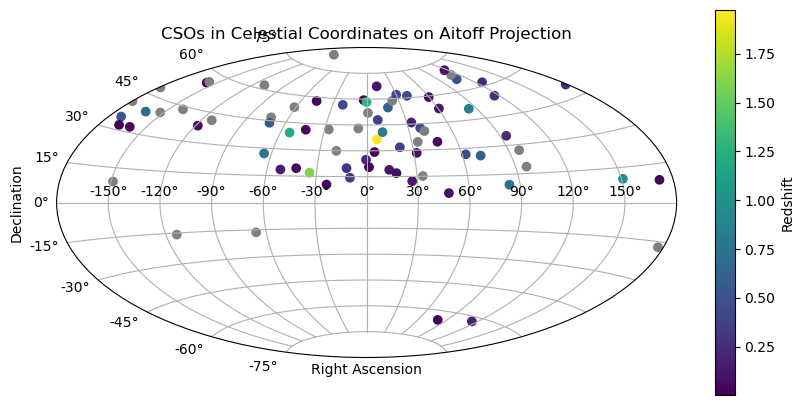

In [6]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='aitoff')
norm = plt.Normalize(-3.14, 3.14)
redshift_list = []
ra_radians=[]
dec_radians=[]
labels = []
for keys in cso_galaxies:
    redshift_list.append(np.nan if (cso_galaxies[keys]['z']=="nan") else float(cso_galaxies[keys]['z']))
    ra_radians.append(np.radians(parse_coordinates_RA(cso_galaxies[keys]['R.A.'])-180))
    dec_radians.append(np.radians(parse_coordinates_deg(cso_galaxies[keys]['Dec.'])))
    labels.append(keys)


valid_redshifts = [z for z in redshift_list if not np.isnan(z)]

min_z = min(valid_redshifts)
max_z = max(valid_redshifts)
norm = plt.Normalize(min_z, max_z)

cmap = plt.get_cmap('viridis')
colors = [cmap(norm(z)) if not np.isnan(z) else "grey" for z in redshift_list]

# Plot the point
ax.scatter(ra_radians,dec_radians, c=colors, label=labels)

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Redshift')
# Setting grid and labels
ax.grid(True)
plt.title('CSOs in Celestial Coordinates on Aitoff Projection')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize='small')

# Adjust the tick labels for RA and Dec to be more readable
#ax.set_xticklabels(['210°', '240°', '270°', '300°', '330°', '0°', '30°', '60°', '90°', '120°', '150°'])
#ax.set_yticklabels(['-60°', '-30°', '0°', '30°', '60°'])
plt.savefig('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/Plots/BF_CSOs_Aitoff.png')
plt.show()

In [7]:

from astropy.coordinates import SkyCoord
# Function to read CSV files and extract data
def read_icecube_data(csv_files):
    frames = []
    for file in csv_files:
        # Attempt to automatically detect the delimiter

        df = pd.read_csv(file, sep='\s+',comment = '#', header=None, names=['MJD[days]' , 'log10(E/GeV)' ,'AngErr[deg]',       'RA[deg]' ,     'Dec[deg]' , 'Azimuth[deg]',  'Zenith[deg]'], )
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Assuming the CSV files are named in a recognizable pattern and stored in a directory named "events"
csv_files = glob('C:/Users/henri/OneDrive/Documents/NTNU/Semester 10/Masteroppgave/icecube_10year_ps/events/*.csv')

# Read the data
data = read_icecube_data(csv_files)
print(data)
# Extract RA and Dec



            MJD[days]  log10(E/GeV)  AngErr[deg]  RA[deg]  Dec[deg]  \
0        54562.379113          3.31         0.48  203.024    16.760   
1        54562.386622          5.17         0.62   75.024   -13.371   
2        54562.387892          3.92         0.56   97.501    11.290   
3        54562.392677          5.57         1.13  305.857   -33.932   
4        54562.404776          5.80         1.11  143.516   -38.279   
...               ...           ...          ...      ...       ...   
1134445  57528.838986          3.22         0.60  188.970    21.796   
1134446  57528.847129          3.00         0.38  323.650    23.620   
1134447  57528.850079          5.29         1.28   21.301   -82.893   
1134448  57528.853812          5.11         0.92   41.021   -41.041   
1134449  57528.856762          3.01         2.76    8.109    37.525   

         Azimuth[deg]  Zenith[deg]  
0             218.374      106.712  
1             349.100       76.646  
2             327.060      101.291  

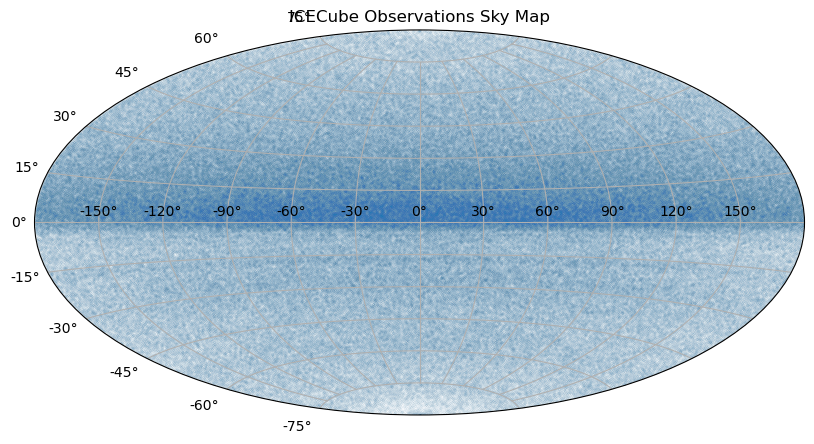

In [39]:
ra = data['RA[deg]']
dec = data['Dec[deg]']

# Convert to astropy SkyCoord object
coords = SkyCoord(ra=ra.values*u.degree, dec=dec.values*u.degree, frame='icrs')

# Plotting
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(projection="aitoff")
ax.scatter(coords.ra.wrap_at('180d').radian, coords.dec.radian, alpha=0.5, s=0.001)

plt.title('ICECube Observations Sky Map')
plt.grid(True)
plt.show()

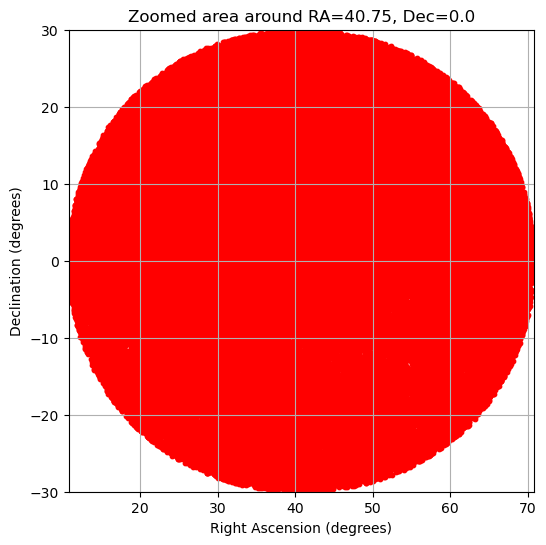

[ 1.45158949 11.89060642  1.5241579  ...  0.96116878  4.9382716
  0.85733882]


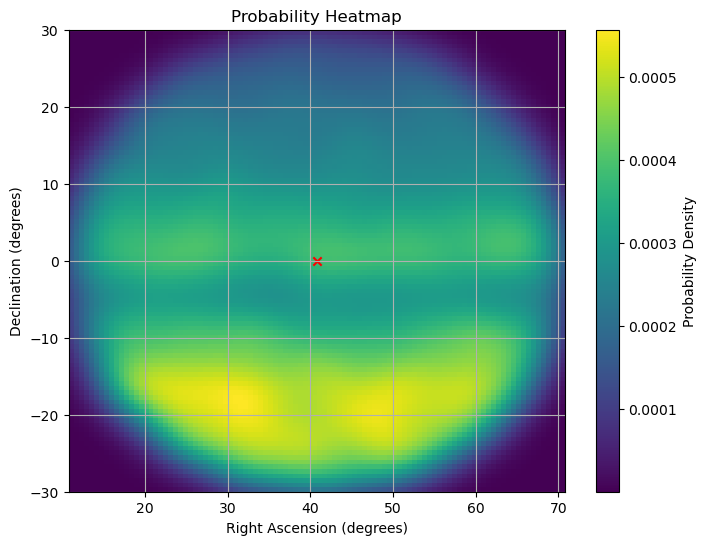

In [8]:
def zoom_sky_map(data, target_coord, radius_deg):
    """
    Plots points within a certain radius of a target coordinate, focusing on the zoomed area.
    
    Parameters:
    - data: DataFrame containing the sky map data.
    - target_coord: A SkyCoord object for the target coordinate.
    - radius_deg: The radius around the target coordinate, in degrees.
    """
    # Convert data to SkyCoord object
    data_coords = SkyCoord(ra=data['RA[deg]'].values*u.degree, dec=data['Dec[deg]'].values*u.degree, frame='icrs')
    
    # Calculate the separation between the target coordinate and each point
    sep = target_coord.separation(data_coords)
    
    # Filter points within the specified radius
    within_radius = sep < radius_deg * u.deg
    
    # Extracting the RA and Dec for points within the radius
    ra_within = data_coords.ra[within_radius].degree
    dec_within = data_coords.dec[within_radius].degree
    
    # Plotting
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Scatter plot of the points within the radius
    ax.scatter(ra_within, dec_within, color='red', s=10)  # Points within radius
    ax.scatter(target_coord.ra.degree, target_coord.dec.degree, color='red', marker='x', label='Target Coordinate')
    # Setting plot limits to focus on the zoomed area
    ax.set_xlim(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg)
    ax.set_ylim(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg)
    
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title(f'Zoomed area around RA={target_coord.ra.degree}, Dec={target_coord.dec.degree}')
    plt.grid(True)
    plt.show()


    
def heatmap_sky_map(data, target_coord, radius_deg, ax):
    # Ensure that AngErr values are positive and non-zero to avoid division by zero
    valid_data_mask = (data['AngErr[deg]'] > 0) & np.isfinite(data['RA[deg]']) & np.isfinite(data['Dec[deg]'])
    valid_data = data[valid_data_mask]
    
    # Filter data around the target_coord within the radius
    coords = SkyCoord(ra=valid_data['RA[deg]'].values*u.degree, dec=valid_data['Dec[deg]'].values*u.degree, frame='icrs')
    sep = target_coord.separation(coords)
    within_radius = sep < radius_deg * u.deg
    
    # If no points, return without plotting
    if not np.any(within_radius):
        
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        kde_values = np.zeros_like(ra_grid)
        # Plotting the heatmap
        cax = ax.imshow(kde_values, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis', interpolation='none')
        fig.colorbar(cax, ax=ax, label='Probability Density')
        
    
    # If only one point, create a Gaussian centered at that point
    elif np.sum(within_radius) == 1:
        single_point = valid_data[within_radius]
        ra_within = single_point['RA[deg]'].values[0]
        dec_within = single_point['Dec[deg]'].values[0]
        ang_err_within = single_point['AngErr[deg]'].values[0]
        
        # Create a meshgrid around the target coordinate
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        
        # Calculate the Gaussian distribution
        variance = (ang_err_within)**2
        gaussian = np.exp(-((ra_grid - ra_within)**2 + (dec_grid - dec_within)**2) / (2 * variance))
        gaussian /= (2 * np.pi * variance)  # Normalize
        
        # Plot the Gaussian
        cax = ax.imshow(gaussian, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis')
        fig.colorbar(cax, ax=ax, label='Probability Density')
        
    else:
        # Regular KDE for multiple points
        ra_within = valid_data['RA[deg]'][within_radius].values
        dec_within = valid_data['Dec[deg]'][within_radius].values
        ang_err_within = valid_data['AngErr[deg]'][within_radius].values
        Energies = valid_data['log10(E/GeV)'][within_radius].values
        N_t = len(ra_within)

        weights = 1 / ang_err_within**2 
        print(weights) # Use square of AngErr as weights for the KDE
        kde = gaussian_kde([ra_within, dec_within], weights=weights)
        
        # Create a grid to evaluate the KDE on
        ra_grid = np.linspace(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg, 100)
        dec_grid = np.linspace(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg, 100)
        ra_grid, dec_grid = np.meshgrid(ra_grid, dec_grid)
        kde_values = kde([ra_grid.ravel(), dec_grid.ravel()]).reshape(ra_grid.shape)
        
        # Plotting the heatmap
        cax = ax.imshow(kde_values, extent=(ra_grid.min(), ra_grid.max(), dec_grid.min(), dec_grid.max()), origin='lower', aspect='auto', cmap='viridis')
        fig.colorbar(cax, ax=ax, label='Probability Density')
    
    # Set limits to focus on the zoomed area
    ax.scatter(target_coord.ra.degree, target_coord.dec.degree, color='red', marker='x', label='Target Coordinate')
    ax.set_xlim(target_coord.ra.degree - radius_deg, target_coord.ra.degree + radius_deg)
    ax.set_ylim(target_coord.dec.degree - radius_deg, target_coord.dec.degree + radius_deg)
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')
    ax.set_title('Probability Heatmap')
    plt.grid(True)
    plt.show()


# Assuming the CSV files are located in a directory named "events"


# Read the data
object_name = "J1735+5049"  # For example
object_info = cso_galaxies[object_name]
zoom_radius = 30  # degrees

# Define your target coordinate (example: RA=203.024, Dec=16.760) and zoom radius in degrees
target_coord = SkyCoord(ra=object_info["R.A."], dec=object_info["Dec."], unit=(u.hourangle, u.deg))
target_coord = SkyCoord(ra=40.75, dec=0 , unit=(u.deg, u.deg))
zoom_sky_map(data, target_coord, zoom_radius)

fig, ax = plt.subplots(figsize=(8, 6))
heatmap_sky_map(data, target_coord, zoom_radius, ax)

In [9]:
from scipy.stats import norm, chi2
from scipy.optimize import minimize
from iminuit import Minuit
from scipy import integrate
from functools import partial

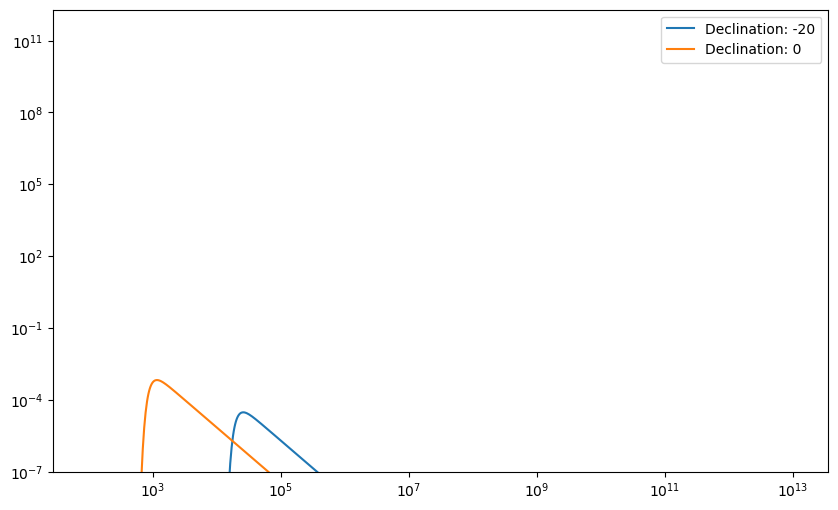

383806399.6188994


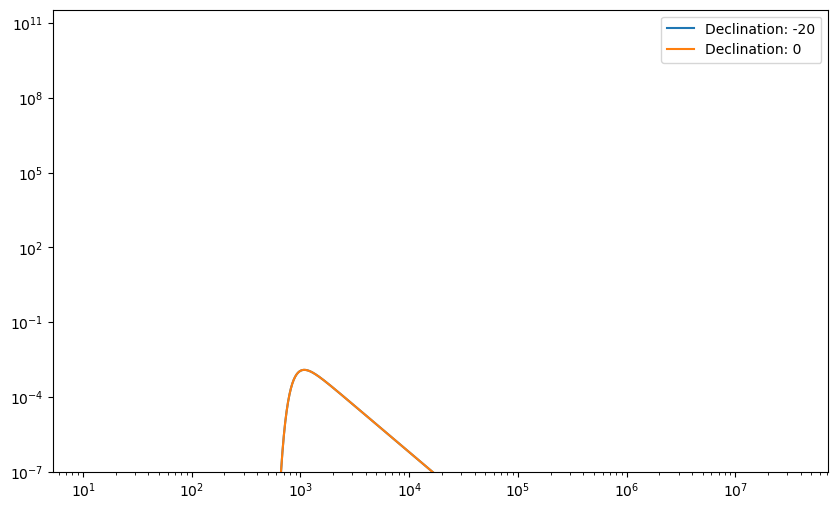

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\henri\AppData\Local\Temp\ipykernel_24304\3448738629.py:158: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_new = data_new[data['Dec[deg]'] > -85]


38.169 -2.5


  0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: 2 values given for 5 function parameter(s)

In [10]:

from scipy.stats import norm, chi2
from scipy.optimize import minimize
from iminuit import Minuit
from scipy import integrate
from functools import partial



def find_band_idx(declination, bands):
    return np.digitize(declination, bands) - 1   

E_min = 1e3
E_max = 1e9
gamma = 2.3
# Calculate the cutoff energy for each down-going band
bands = np.linspace(-85, 0, 21) 

cutoffs = E_min * abs(bands) +E_min
band2 =  np.array((0, 15, 85))
bands = np.concatenate((bands,band2))

cutoffs = np.concatenate((cutoffs, [E_min,E_min]))
Neutrino_energies = np.logspace((data['log10(E/GeV)'].min()),(data['log10(E/GeV)'].max()),1000)


#print(cutoffs)


def power_law(E, gamma,E_cut=E_min):
    
   

    return E**(-gamma)*np.exp(-(E_cut/E)**6)

def ext_func(E, gamma,E_cut=E_min):
    return np.exp(E)*power_law(np.exp(E), gamma,E_cut)  


  # Example neutrino energies in GeV
                                     
                        

def signal_space_pdf(event, source, sigma_i):
    # Assuming Gaussian spatial PDF
    return  np.exp(-0.5 * ((abs(event[0] - source[0])+abs(event[1] - source[1]))**2 / sigma_i**2)) / (2 * np.pi * sigma_i**2)
# Define the energy PDF for signal events
def signal_energy_pdf(event_energy, spectral_index, declination):

    E_cut = cutoffs[find_band_idx(declination, bands)]
    #print(E_cut)
    vals = power_law(Neutrino_energies, spectral_index,E_cut)
    integral = integrate.simps(vals, Neutrino_energies)
    
    C = 1 / integral 
    #print(C)
    # This would be specific to your expected energy distribution
    return C*power_law(event_energy,spectral_index,E_cut) # Example power-law with exponential cutoff

Test_muon_energies = np.logspace(2,13,1000)  # Example muon energies in GeV
  # Example declinations in degrees
vals = signal_energy_pdf(Test_muon_energies, gamma, -20)
vals_2 = signal_energy_pdf(Test_muon_energies, gamma, 0)
plt.figure(figsize=(10, 6))
plt.plot(Test_muon_energies, vals, label=f'Declination: {-20}')
plt.plot(Test_muon_energies,vals_2, label=f'Declination: {0}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7)
plt.legend()
plt.show()




# Define the background PDFs based on scrambled data
def background_space_pdf(event,d_i):
    i = find_band_idx(d_i, bands)
    band_width = bands[i+1] - bands[i]
    if band_width == 0:
        return event
    return 1 / band_width
    # Flat in right ascension, dependent on declination
    
def Background_spec(E):
    return E**-3.7*np.exp(-(E_min/E)**6)

def ext_back_func(E):
    return np.exp(E)*Background_spec(np.exp(E))



#print(E_cut)
vals = Background_spec(Neutrino_energies)
integral = integrate.simps(vals, Neutrino_energies)
C_back = 1 / integral
def background_energy_pdf(event_energy, declination,C):
    # This would be estimated from your scrambled data

   
    return C*Background_spec(event_energy) # Example power-law background energy PDF


vals = background_energy_pdf(Neutrino_energies, -20,C_back)
vals_2 = background_energy_pdf(Neutrino_energies, 0,C_back)

print(C_back*np.trapz(vals, Neutrino_energies))
plt.figure(figsize=(10, 6))
plt.plot(Neutrino_energies, vals, label=f'Declination: {-20}')
plt.plot(Neutrino_energies,vals_2, label=f'Declination: {0}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7)
plt.legend()
plt.show()
# Likelihood function
def likelihood(ns,gamma, data, source,C_back = C_back):
    #ns, gamma = params
    #print(data)
    
    N = len(data)
    if ns < 0:
        return 1e500
    total_likelihood = 1
    for index,  event in data.iterrows():
        En = 10**event['log10(E/GeV)']
       
        event_space = np.array([event['RA[deg]'], event['Dec[deg]']])
        bin_idx = find_band_idx(En, Neutrino_energies)
        width = Neutrino_energies[bin_idx+1] - Neutrino_energies[bin_idx]
        s_i = signal_space_pdf(event_space, source, event['AngErr[deg]'])*grid_spacing * signal_energy_pdf(En, gamma, event['Dec[deg]'])*width
        
        
        b_i = background_space_pdf(event_space,event['Dec[deg]'])*grid_spacing * background_energy_pdf(En, event['Dec[deg]'],C_back)*width
        if (s_i > 1e-2):

            print('Signal:',s_i)
            print('Background:',b_i)
        if(b_i > 1):
            print('Background:',b_i)
            print('Signal:',s_i)
        #print(background_space_pdf(event_space,event['Dec[deg]']))
        total_likelihood = total_likelihood* (ns/N * s_i + (1 - ns/N) * b_i)
  
            
        
    #print(total_likelihood)
    if total_likelihood == 0:
        return -np.log(1e-50)
    return -np.log(total_likelihood)  # Negative log-likelihood for minimization

def fitting_function(ns,gamma):
    return partial_function(ns,gamma)

def TS_stat(data, source):
    target_coord = SkyCoord(ra=source[0], dec=source[1], unit=(u.deg, u.deg))
    
    data_new= data[data['Dec[deg]'] < 85]  
    data_new = data_new[data['Dec[deg]'] > -85]  

        # Ensure that AngErr values are positive and non-zero to avoid division by zero
    valid_data_mask = (data_new['AngErr[deg]'] > 0) & np.isfinite(data_new['RA[deg]']) & np.isfinite(data_new['Dec[deg]'])
    valid_data = data_new[valid_data_mask]

    # Filter data around the target_coord within the radius
    coords = SkyCoord(ra=valid_data['RA[deg]'].values*u.degree, dec=valid_data['Dec[deg]'].values*u.degree, frame='icrs')
    sep = target_coord.separation(coords)
    within_radius = sep < zoom_radius * u.deg

    data_using = valid_data[within_radius]
    N = len(data_using)
    initial_ns = N
    initial_gamma = 2.3
    init_guess = {'ns': initial_ns, 'gamma': initial_gamma}

    partial_function = partial(likelihood, data=data_using, source=source)
    #best_fit = minimize(likelihood, x0=[initial_ns, initial_gamma], args=(data, source),bounds = ((0,None),(1,4)), method='nelder-mead')
    m = Minuit(partial_function, ns=initial_ns, gamma=initial_gamma)
    m.migrad()
    print(initial_ns,initial_gamma)
    print(m.values)
    ts = -2 * (likelihood([0, best_fit.x[1]], data, source) - likelihood(best_fit.x, data, source))
    return ts

# Define the grid parameters
grid_size = 5  # Number of squares in each dimension
grid_spacing = 1  # Spacing between squares

# Define the center point (t) in RA and Dec
t_ra = 40.669  # Example RA value
t_dec = 0.0  # Example Dec value

# Create the grid
ra_grid = np.linspace(t_ra - grid_size/2 * grid_spacing, t_ra + grid_size/2 * grid_spacing, grid_size)
dec_grid = np.linspace(t_dec - grid_size/2 * grid_spacing, t_dec + grid_size/2 * grid_spacing, grid_size)
TS_vals = np.zeros((grid_size, grid_size))
# Calculate the ts value for each square in the grid
for i in tqdm(range (len(ra_grid))):
    for j in range (len(dec_grid)):
        # Perform the ts calculation for each square
        print(ra_grid[i],dec_grid[j])
        TS_vals[i, j] = TS_stat(data, np.array([ra_grid[i], dec_grid[j]]))
        


plt.imshow(TS_vals, origin='lower', cmap='hot', extent=[ra_grid[0], ra_grid[-1], dec_grid[0], dec_grid[-1]])
plt.colorbar(label='TS')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('TS Values')
plt.show()



# Significance evaluation
# You would need to perform the scrambling of your data many times to create the null TS distribution
#null_ts_distribution = ...  # Perform many pseudo-experiments to obtain this
#p_value = np.mean(null_ts_distribution >= ts)

# Sensitivity and upper limits
# You would need to define how to calculate sensitivity and upper limits based on your p-value and null TS distribution



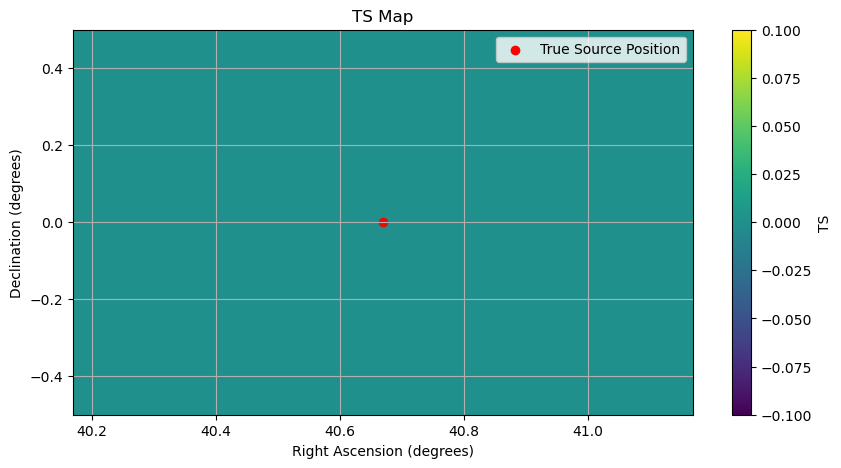

[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]]


In [202]:
plt.figure(figsize=(10, 5))
plt.imshow(TS_vals, extent=[ra_grid[0], ra_grid[-1], dec_grid[0], dec_grid[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='TS')
plt.scatter(40.669, 0, color='red', label='True Source Position')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('TS Map')
plt.legend()
plt.grid(True)
plt.show()
print(TS_vals)


-1.0074068342448812e+26 1.0074068342448814e+28


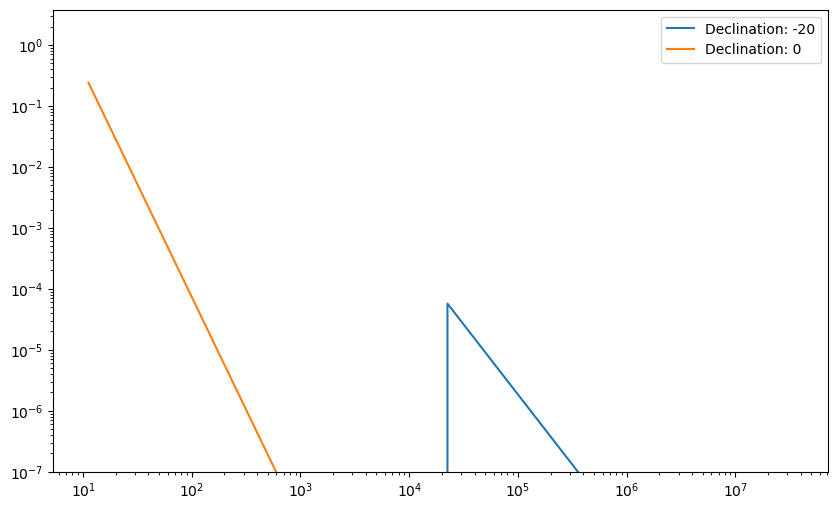

1847.1351248025412


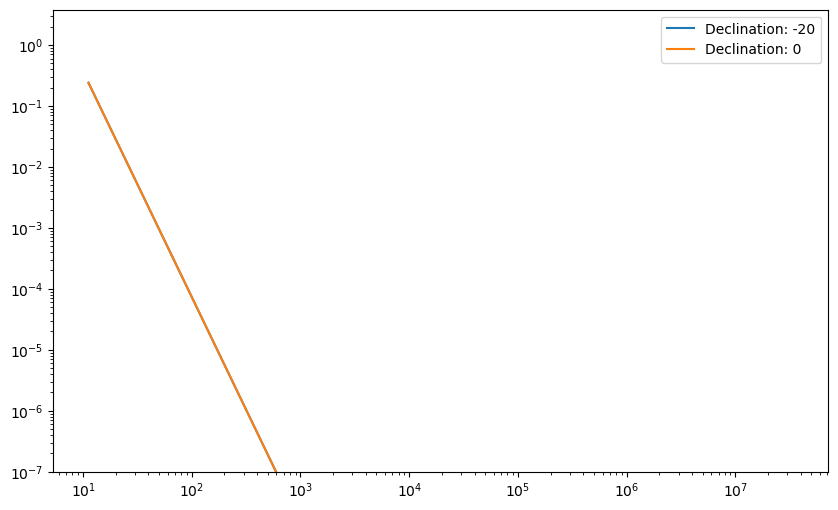

  0%|          | 0/5 [00:00<?, ?it/s]

start fitting
4.0 2.3 2705 49515.25705422457
4.00434614231163 2.3 2705 49515.12923285688
3.9956538576883704 2.3 2705 49515.38499930451
4.043461423116297 2.3 2705 49513.98436709739
3.9565385768837027 2.3 2705 49516.54211323702
4.0 2.302499031830493 2705 49515.28306856277
4.0 2.2975009681695067 2705 49515.23145154742
4.0 2.318926086967144 2705 49515.4642007159
4.0 2.2810739130328557 2705 49515.07352124545
8.492576708047146 2.1434363858396512 2705 49422.91044769173
11.248928655250758 2.0473791672775006 2705 49388.296742699444
15.56188401761394 1.8970752496984598 2705 49350.85530931961
21.320731978882403 1.6963828389041944 2705 49322.785002152945
24.889256705424163 1.5720218842192808 2705 49316.29206209633
24.949176538853852 1.5720218842192808 2705 49315.9973649969
24.829336871994474 1.5720218842192808 2705 49316.58751398196
25.223714560138998 1.5720218842192808 2705 49314.6566921744
24.55479885070933 1.5720218842192808 2705 49317.95094996282
24.889256705424163 1.5909089803935141 2705 4931

183.81845724376515 2.2681802179170103 2705 49104.98533024062
start fitting
4.0 2.3 3011 54813.69286779209
4.004572761293686 2.3 3011 54813.49626909189
3.995427238706314 2.3 3011 54813.889658068714
4.045727612936861 2.3 3011 54811.735437346746
3.9542723870631393 2.3 3011 54815.669456907824
4.0 2.3026293377452434 3011 54813.748626202745
4.0 2.2973706622547563 3011 54813.63774124309
4.0 2.316910984742458 3011 54814.06239917802
4.0 2.283089015257542 3011 54813.34947629151
8.69482798122364 2.069390188666153 3011 54671.573634437365
11.50423357532629 1.931392269124188 3011 54621.39406928076
15.499745284355278 1.7351328523603815 3011 54576.600921261066
19.237653703505597 1.5515269015628435 3011 54560.15990250766
19.290940870113737 1.5515269015628435 3011 54559.62776999103
19.184366536897457 1.5515269015628435 3011 54560.693438499104
19.467081485445338 1.5515269015628435 3011 54557.878704695715
19.008225921565856 1.5515269015628435 3011 54562.467118490036
19.237653703505597 1.5683980209262698 3

285.08431338684795 2.2360237585680998 3011 54087.51640809368
start fitting
4.0 2.3 3309 59816.32072230603
4.004776871039096 2.3 3309 59815.95920573981
3.995223128960905 2.3 3309 59816.68261932743
4.041360925630269 2.3 3309 59813.203027797106
3.9586390743697306 2.3 3309 59819.46694124103
4.0 2.302746700848915 3309 59816.376066919045
4.0 2.297253299151085 3309 59816.26664334298
4.0 2.3130392638651487 3309 59816.594618863135
4.0 2.286960736134851 3309 59816.075350172534
8.541393005356646 2.181314315609561 3309 59576.30554339129
11.400889697641295 2.106583650032789 3309 59482.25695423012
16.068501828729996 1.9845993294523085 3309 59372.531625318654
23.164662629434257 1.7991468261823238 3309 59268.153903381564
29.449427556490537 1.634899506974124 3309 59220.80205604307
33.33296248440374 1.5334064187895318 3309 59211.308040838616
33.3741127623362 1.5334064187895318 3309 59210.890879745035
33.29181220647127 1.5334064187895318 3309 59211.72571206391
33.63910197694369 1.5334064187895318 3309 59

459.1750826554617 2.318067459226252 3309 58404.49064848183
start fitting
4.0 2.3 3577 64516.71815151194
4.004961003551887 2.3 3577 64516.18688985802
3.9950389964481126 2.3 3577 64517.24999602425
4.036042302439915 2.3 3577 64512.871651967216
3.9639576975600845 2.3 3577 64520.59541654117
4.0 2.302852577043826 3577 64516.73918448141
4.0 2.2971474229561735 3577 64516.699043798064
4.0 2.3114029632882533 3577 64516.81367512543
4.0 2.2885970367117463 3577 64516.653393407854
8.524262549254598 2.270296501236812 3577 64179.02771990589
11.448614040911028 2.251097025085753 3577 64040.94184881811
16.399843346518537 2.218590327705956 3577 63868.83958638048
24.909597218981073 2.1627205675242953 3577 63665.23220896805
35.519846853724104 2.093060256374885 3577 63492.32582215682
50.63248673957472 1.9938400463913104 3577 63324.68324035679
70.49540781110234 1.8634324396137993 3577 63182.232630302395
92.54835434074609 1.7186464854750771 3577 63089.92101219643
110.90385317200497 1.5981356771618378 3577 6305

655.5776012139992 2.384641696629586 3577 62313.55153555978
start fitting
4.0 2.3 3716 67244.32064016967
4.005064785683011 2.3 3716 67243.70915167942
3.9949352143169894 2.3 3716 67244.93280904369
4.034769637131225 2.3 3716 67240.13640006336
3.9652303628687746 2.3 3716 67248.53694636692
4.0 2.302912251769253 3716 67244.30394934102
4.0 2.2970877482307466 3716 67244.33960369947
4.0 2.31093890441136 3716 67244.26962505192
4.0 2.2890610955886395 3716 67244.40372135703
8.55440525957247 2.322872567197649 3716 66860.71863838649
11.516650541373293 2.337749186734635 3716 66702.60073942477
16.538549420750282 2.3629695421996932 3716 66504.94152731376
25.236248848055787 2.4066500456414697 3716 66268.2205431558
36.262554321884096 2.462024984523307 3716 66061.84001871868
52.46718698990916 2.5434058736819094 3716 65851.07925050442
75.37321343268286 2.658441668518632 3716 65648.15375788262
105.69372470639412 2.810713566175833 3716 65468.230625868106
144.5245830179873 3.005725069424817 3716 65317.9052301

 20%|██        | 1/5 [17:19<1:09:18, 1039.59s/it]

730.8653214123406 2.4307535464439907 3716 64678.63947933076


start fitting
4.0 2.3 2721 49897.128446515286
4.004362868937773 2.3 2721 49897.00638116133
3.995637131062227 2.3 2721 49897.250631458315
4.043628689377728 2.3 2721 49895.91313483292
3.9563713106222718 2.3 2721 49898.355717728766
4.0 2.3025086496405303 2721 49897.157656821735
4.0 2.2974913503594694 2721 49897.099625223884
4.0 2.3196193209119684 2721 49897.36714096758
4.0 2.280380679088031 2721 49896.91354804959
8.455303867999248 2.113010799495148 2721 49809.799018437196
11.146627003820072 2.000055908790164 2721 49778.02207238451
15.214171196706037 1.8293409903063982 2721 49745.89505836707
20.009103145525106 1.6280975918426506 2721 49726.99904250359
22.024154758143784 1.5435258317151455 2721 49724.993990917515
22.085586356158224 1.5435258317151455 2721 49724.67027753808
21.962723160129343 1.5435258317151455 2721 49725.3186417265
22.33311156291301 1.5435258317151455 2721 49723.37534507882
21.715197953374556 1.5435258317151455 2721 49726.63634979186
22.024154758143784 1.5631101695644356 27

177.58183265539688 2.2350814370686853 2721 49510.42925513446
start fitting
4.0 2.3 3007 54719.786550969984
4.0045688426797295 2.3 3007 54719.594074350665
3.99543115732027 2.3 3007 54719.979218624976
4.045688426797297 2.3 3007 54717.87031652091
3.9543115732027028 2.3 3007 54721.72189003525
4.0 2.3026270845422174 3007 54719.84510489834
4.0 2.297372915457782 3007 54719.7286412119
4.0 2.316719947476424 3007 54720.17009894938
4.0 2.2832800525235757 3007 54719.42909785979
8.605492536206542 2.0626066028097028 3007 54583.382303909624
11.290138411544413 1.9242246166075665 3007 54536.82637262941
15.096906682752548 1.7280020312676077 3007 54495.65440865002
18.57252061961821 1.5488490322543704 3007 54481.269191091
18.62579882943883 1.5488490322543704 3007 54480.74191818552
18.51924240979759 1.5488490322543704 3007 54481.79791731971
18.797778536967687 1.5488490322543704 3007 54479.04973075798
18.347262702268733 1.5488490322543704 3007 54483.51463203994
18.57252061961821 1.5655318721848208 3007 5447

271.70435221063576 2.2399697094715587 3007 54033.97785933338
start fitting
4.0 2.3 3330 60133.40059121677
4.004789514933138 2.3 3330 60133.04504693285
3.995210485066863 2.3 3330 60133.75650877755
4.041978072324809 2.3 3330 60130.29700741586
3.958021927675191 2.3 3330 60136.532850666285


 20%|██        | 1/5 [23:31<1:34:07, 1411.76s/it]


KeyboardInterrupt: 

In [279]:

from scipy.stats import norm, chi2
from scipy.optimize import minimize
from iminuit import Minuit
from scipy import integrate
from functools import partial



def find_band_idx(declination, bands):
    return np.digitize(declination, bands) - 1   

E_min = 1e3
E_max = 1e9
gamma = 2.3
# Calculate the cutoff energy for each down-going band
bands = np.linspace(-85, 0, 21) 

cutoffs = E_min * abs(bands) +E_min
band2 =  np.array((0, 15, 85))
bands = np.concatenate((bands,band2))

cutoffs = np.concatenate((cutoffs, [E_min,E_min]))
Neutrino_energies = np.logspace((data['log10(E/GeV)'].min()),(data['log10(E/GeV)'].max()),1000)


#print(cutoffs)


def power_law(E, gamma,E_cut=E_min):
    
   
    if E < E_cut:
        return 0
    else:

        return E**(-gamma)

def ext_func(E, gamma,E_cut=E_min):
    return np.exp(E)*power_law(np.exp(E), gamma,E_cut)  


  # Example neutrino energies in GeV
                                     
                        

def signal_space_pdf(event, source, sigma_i):
    # Assuming Gaussian spatial PDF
    return  np.exp(-0.5 * ((abs(event[0] - source[0])+abs(event[1] - source[1]))**2 / sigma_i**2)) / (2 * np.pi * sigma_i**2)
# Define the energy PDF for signal events
def signal_energy_pdf(event_energy, spectral_index, declination):

    E_cut = cutoffs[find_band_idx(declination, bands)]
    #print(E_cut)
    vals = []
    for i in range(0,len(Neutrino_energies)):
        vals.append(power_law(Neutrino_energies[i], spectral_index,E_cut))

    integral = integrate.simps(vals, Neutrino_energies)
    
    C = 1 / integral 
    #print(C)
    # This would be specific to your expected energy distribution
    return C*power_law(event_energy,spectral_index,E_cut) # Example power-law with exponential cutoff

  # Example muon energies in GeV
  # Example declinations in degrees
vals = []
vals2 = []
for i in range(0,len(Neutrino_energies)):
    vals.append(signal_energy_pdf(Neutrino_energies[i], gamma, -20))
    vals2.append(signal_energy_pdf(Neutrino_energies[i], gamma, 0))

plt.figure(figsize=(10, 6))
plt.plot(Neutrino_energies, vals, label=f'Declination: {-20}')
plt.plot(Neutrino_energies,vals_2, label=f'Declination: {0}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7)
plt.legend()
plt.show()




# Define the background PDFs based on scrambled data
def background_space_pdf(event,d_i):
    i = find_band_idx(d_i, bands)
    band_width = bands[i+1] - bands[i]
    if band_width == 0:
        return event
    return 1 / band_width
    # Flat in right ascension, dependent on declination
    
def Background_spec(E):
    return E**-3.7

def ext_back_func(E):
    return np.exp(E)*Background_spec(np.exp(E))



#print(E_cut)
vals = Background_spec(Neutrino_energies)
integral = integrate.simps(vals, Neutrino_energies)
C_back = 1 / integral
def background_energy_pdf(event_energy, declination,C):
    # This would be estimated from your scrambled data

   
    return C*Background_spec(event_energy) # Example power-law background energy PDF


vals = background_energy_pdf(Neutrino_energies, -20,C_back)
vals_2 = background_energy_pdf(Neutrino_energies, 0,C_back)

print(C_back*np.trapz(vals, Neutrino_energies))
plt.figure(figsize=(10, 6))
plt.plot(Neutrino_energies, vals, label=f'Declination: {-20}')
plt.plot(Neutrino_energies,vals_2, label=f'Declination: {0}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7)
plt.legend()
plt.show()


# Likelihood function
def likelihood(ns,gamma):
    #ns, gamma = params
    #print(data)
    
    N = len(data_using)
    
    total_likelihood = 0
    for index,  event in data_using.iterrows():
        En = 10**event['log10(E/GeV)']
       
        event_space = np.array([event['RA[deg]'], event['Dec[deg]']])
        bin_idx = find_band_idx(En, Neutrino_energies)
        width = Neutrino_energies[bin_idx+1] - Neutrino_energies[bin_idx]
        s_i = signal_space_pdf(event_space, source, event['AngErr[deg]'])*grid_spacing * signal_energy_pdf(En, gamma, event['Dec[deg]'])*width
        
        
        b_i = background_space_pdf(event_space,event['Dec[deg]'])*grid_spacing * background_energy_pdf(En, event['Dec[deg]'],C_back)*width
        
        #print(background_space_pdf(event_space,event['Dec[deg]']))
        total_likelihood = total_likelihood + np.log( (ns/N * s_i + (1 - ns/N) * b_i))
    
        
            
    print(ns,gamma,N,-total_likelihood) 
    #print(total_likelihood)

    return -(total_likelihood)  # Negative log-likelihood for minimization


# Define the grid parameters
grid_size = 5  # Number of squares in each dimension
grid_spacing = 1  # Spacing between squares

# Define the center point (t) in RA and Dec
t_ra = 40.669  # Example RA value
t_dec = 0.0  # Example Dec value

# Create the grid
ra_grid = np.linspace(t_ra - grid_size/2 * grid_spacing, t_ra + grid_size/2 * grid_spacing, grid_size)
dec_grid = np.linspace(t_dec - grid_size/2 * grid_spacing, t_dec + grid_size/2 * grid_spacing, grid_size)
TS_vals = np.zeros((grid_size, grid_size))
zoom_radius = 5
# Calculate the ts value for each square in the grid


        # Perform the ts calculation for each square
        

for i in tqdm(range (len(ra_grid))):
    for j in tqdm(range (len(dec_grid))):

        source = np.array([ra_grid[i], dec_grid[j]])

        target_coord = SkyCoord(ra=source[0], dec=source[1], unit=(u.deg, u.deg))

        data_new= data[data['Dec[deg]'] < 85]  
        data_new = data_new[data_new['Dec[deg]'] > -85]  

            # Ensure that AngErr values are positive and non-zero to avoid division by zero
        valid_data_mask = (data_new['AngErr[deg]'] > 0) & np.isfinite(data_new['RA[deg]']) & np.isfinite(data_new['Dec[deg]'])
        valid_data = data_new[valid_data_mask]

        # Filter data around the target_coord within the radius
        coords = SkyCoord(ra=valid_data['RA[deg]'].values*u.degree, dec=valid_data['Dec[deg]'].values*u.degree, frame='icrs')
        sep = target_coord.separation(coords)
        within_radius = sep < zoom_radius * u.deg

        data_using = valid_data[within_radius]
        N = len(data_using)
        initial_ns = 4
        initial_gamma = 2.3
        init_guess = {'ns': initial_ns, 'gamma': initial_gamma}
        print('start fitting')
        
        #best_fit = minimize(likelihood, x0=[initial_ns, initial_gamma], args=(data, source),bounds = ((0,None),(1,4)), method='nelder-mead')
        m = Minuit(likelihood, ns=initial_ns, gamma=initial_gamma)
        m.migrad()
        print('End fitting')
        print(initial_ns,initial_gamma)
        print(m.values)
        ts = -2 * (likelihood(0, m.values[1]) - likelihood(m.values[0], m.values[1]))
        # Perform the ts calculation for each square
       
        TS_vals[i, j] = ts
        




# Significance evaluation
# You would need to perform the scrambling of your data many times to create the null TS distribution
#null_ts_distribution = ...  # Perform many pseudo-experiments to obtain this
#p_value = np.mean(null_ts_distribution >= ts)

# Sensitivity and upper limits
# You would need to define how to calculate sensitivity and upper limits based on your p-value and null TS distribution



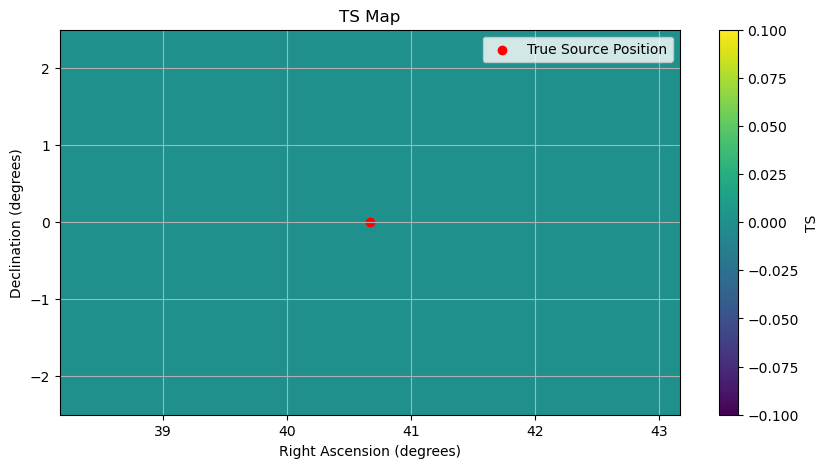

[[-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.]]


In [274]:
plt.figure(figsize=(10, 5))
plt.imshow(TS_vals, extent=[ra_grid[0], ra_grid[-1], dec_grid[0], dec_grid[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='TS')
plt.scatter(40.669, 0, color='red', label='True Source Position')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('TS Map')
plt.legend()
plt.grid(True)
plt.show()
print(TS_vals)

In [ ]:

    #ns, gamma = params
    #print(data)

source = np.array([ra_grid[5], dec_grid[5]])

target_coord = SkyCoord(ra=source[0], dec=source[1], unit=(u.deg, u.deg))

data_new= data[data['Dec[deg]'] < 85]  
data_new = data_new[data_new['Dec[deg]'] > -85]  

    # Ensure that AngErr values are positive and non-zero to avoid division by zero
valid_data_mask = (data_new['AngErr[deg]'] > 0) & np.isfinite(data_new['RA[deg]']) & np.isfinite(data_new['Dec[deg]'])
valid_data = data_new[valid_data_mask]

# Filter data around the target_coord within the radius
coords = SkyCoord(ra=valid_data['RA[deg]'].values*u.degree, dec=valid_data['Dec[deg]'].values*u.degree, frame='icrs')
sep = target_coord.separation(coords)
within_radius = sep < zoom_radius * u.deg

data_using = valid_data[within_radius]

N = len(data_using)

total_likelihood = 1
for index,  event in data_using.iterrows():
    En = 10**event['log10(E/GeV)']
    
    event_space = np.array([event['RA[deg]'], event['Dec[deg]']])
    bin_idx = find_band_idx(En, Neutrino_energies)
    width = Neutrino_energies[bin_idx+1] - Neutrino_energies[bin_idx]
    s_i = signal_space_pdf(event_space, source, event['AngErr[deg]'])*grid_spacing * signal_energy_pdf(En, gamma, event['Dec[deg]'])*width
    
    
    b_i = background_space_pdf(event_space,event['Dec[deg]'])*grid_spacing * background_energy_pdf(En, event['Dec[deg]'],C_back)*width

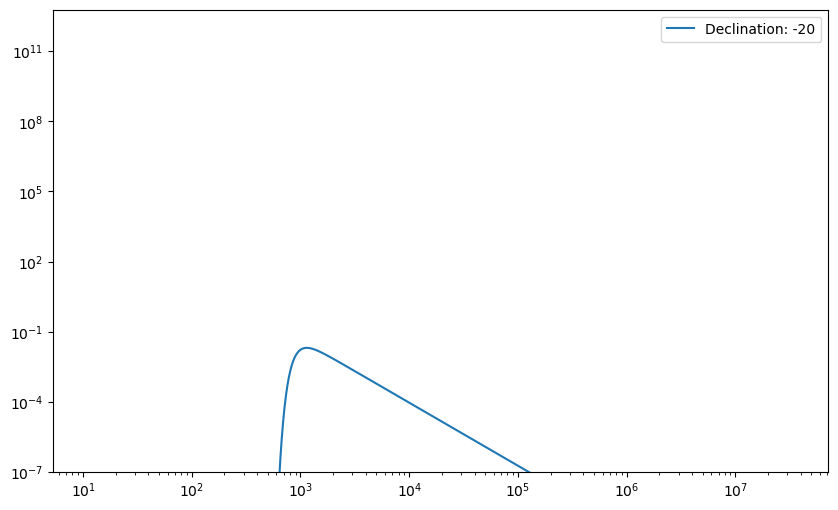

0.9925692070488554
23.931119734586964
2.18 5.06


In [269]:
back_vals = []
for i in range(0,len(Neutrino_energies)):
    bin_idx = find_band_idx(Neutrino_energies[i], Neutrino_energies)
    width = Neutrino_energies[bin_idx] - Neutrino_energies[bin_idx-1]
    back_vals.append(background_energy_pdf(Neutrino_energies[i], -20,C_back)*width)
plt.figure(figsize=(10, 6))
plt.plot(Neutrino_energies, back_vals, label=f'Declination: {-20}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-7)
plt.legend()
plt.show()
print(sum(back_vals))
print(np.trapz(back_vals, Neutrino_energies))
print(data_using['log10(E/GeV)'].min(),data_using['log10(E/GeV)'].max())

{'R.A.': '17:35:49.01', 'Dec.': '+50:49:11.57', 'z': 0.835, 'Ang_size': 8.0, 'lin_size': 0.061, 'Turnover_freq': 6.4, 'Turnover_flux_den': 0.972, 'class': 2.0}


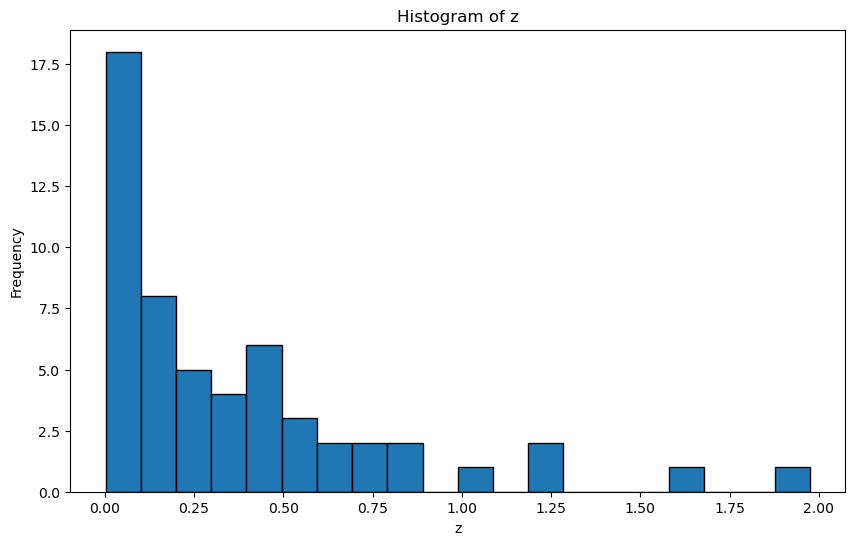

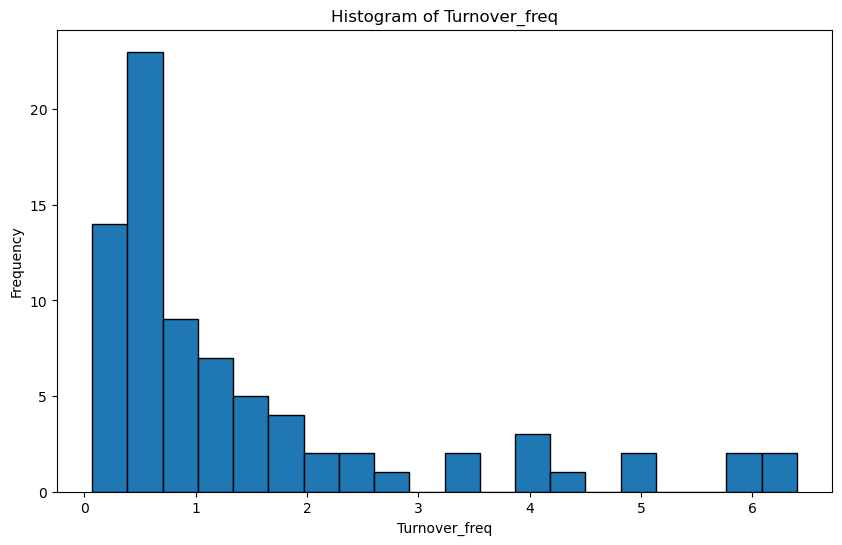

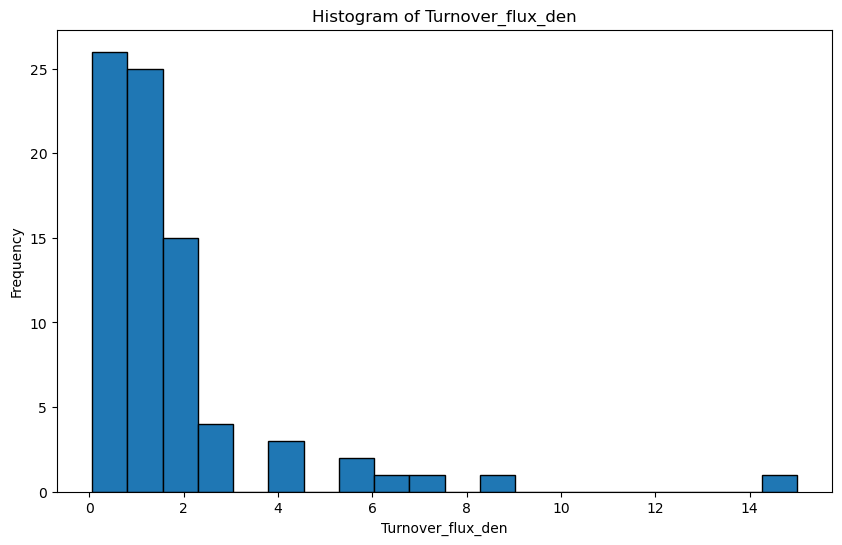

80 80


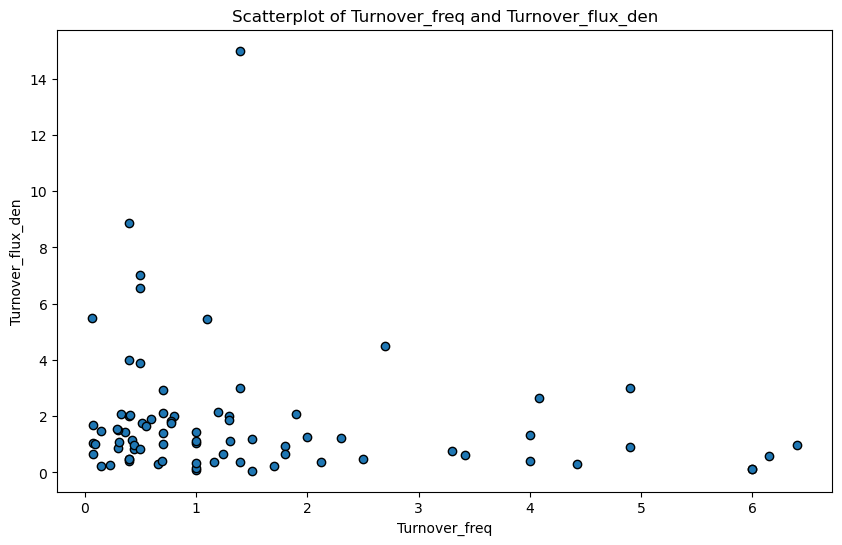

In [ ]:
#### Histogram part

def plot_histogram_from_dict(data_dict, parameter, bins=10):
    """
    Plots a histogram for a specified parameter from a given dictionary.

    :param data_dict: Dictionary containing astronomical objects and their properties.
    :param parameter: The parameter (key within inner dictionaries) to plot the histogram for.
    :param bins: Number of bins for the histogram.
    """
    # Extract values for the specified parameter, filtering out non-numeric values and 'nan'
    values = [float(obj[parameter]) for obj in data_dict.values() if obj[parameter] != 'nan' and is_float(obj[parameter])]
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=bins, edgecolor='black')
    plt.title(f'Histogram of {parameter}')
    plt.xlabel(parameter)
    plt.ylabel('Frequency')
    plt.show()

def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False


def plot_scatter_from_dict(data_dict, parameter1,parameter2):
    """
    Plots a histogram for a specified parameter from a given dictionary.

    :param data_dict: Dictionary containing astronomical objects and their properties.
    :param parameter: The parameter (key within inner dictionaries) to plot the histogram for.
    :param bins: Number of bins for the histogram.
    """
    # Extract values for the specified parameter, filtering out non-numeric values and 'nan'
    values1 = [float(obj[parameter1]) for obj in data_dict.values() if obj[parameter1] != np.nan and is_float(obj[parameter1]) and obj[parameter2] != np.nan and is_float(obj[parameter2])]
    values2 = [float(obj[parameter2]) for obj in data_dict.values() if obj[parameter1] != np.nan and is_float(obj[parameter1]) and obj[parameter2] != np.nan and is_float(obj[parameter2])]

    print(len(values1),len(values2))
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.scatter(values1, values2, edgecolor='black')
    plt.title(f'Scatterplot of {parameter1} and {parameter2}')
    plt.xlabel(parameter1)
    plt.ylabel(parameter2)
    plt.show()
print(cso_galaxies['J1735+5049'])
plot_histogram_from_dict(cso_galaxies, 'z', bins=20)
plot_histogram_from_dict(cso_galaxies, 'Turnover_freq', bins=20)
plot_histogram_from_dict(cso_galaxies, 'Turnover_flux_den', bins=20)
plot_scatter_from_dict(cso_galaxies, 'Turnover_freq', 'Turnover_flux_den')

Index(['Object Name', 'R.A.', 'Dec.', 'z', 'Ang_size', 'lin_size',
       'Turnover_freq', 'Turnover_flux_den', 'class', 'major_axis_comb'],
      dtype='object')
                          z  Turnover_freq  Turnover_flux_den  Ang_size  \
z                  1.000000       0.097669          -0.049572 -0.128253   
Turnover_freq      0.097669       1.000000          -0.147264 -0.238877   
Turnover_flux_den -0.049572      -0.147264           1.000000  0.004377   
Ang_size          -0.128253      -0.238877           0.004377  1.000000   
lin_size           0.472886      -0.440568           0.080211  0.392095   
class              0.324551      -0.195847           0.298542 -0.243292   
major_axis_comb   -0.972397      -0.590072           0.971918  0.977045   

                   lin_size     class  major_axis_comb  
z                  0.472886  0.324551        -0.972397  
Turnover_freq     -0.440568 -0.195847        -0.590072  
Turnover_flux_den  0.080211  0.298542         0.971918  
Ang_size

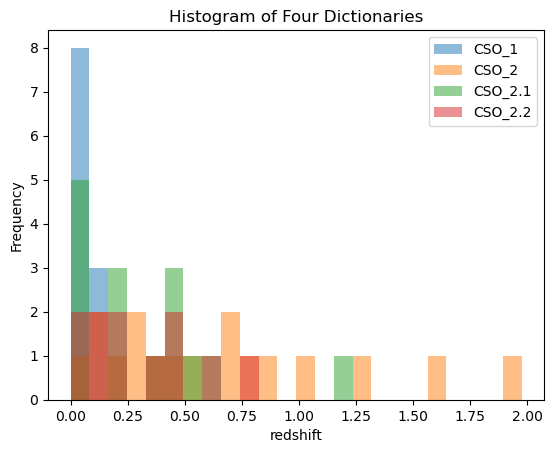

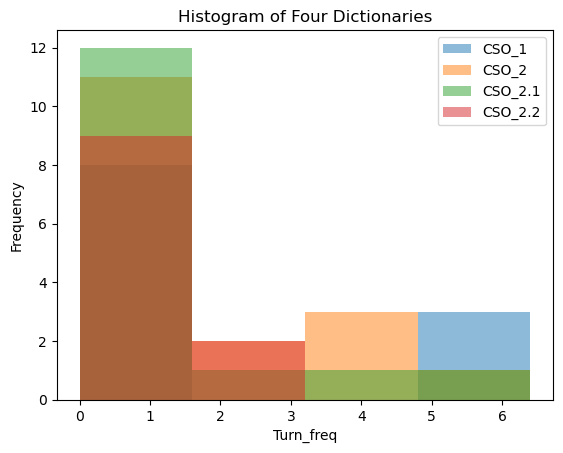

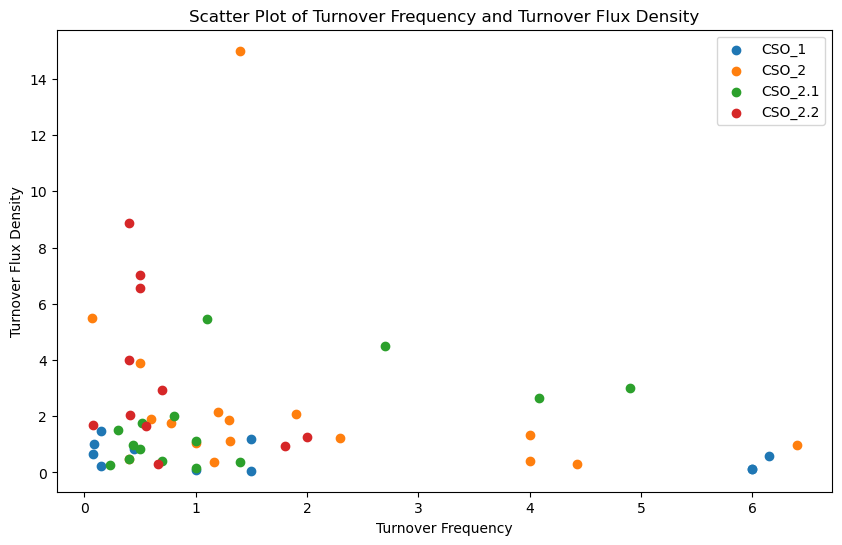

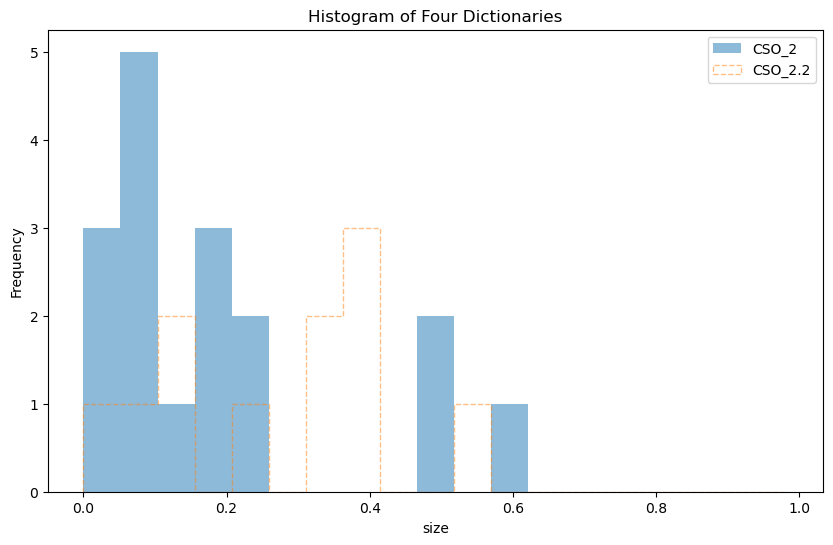

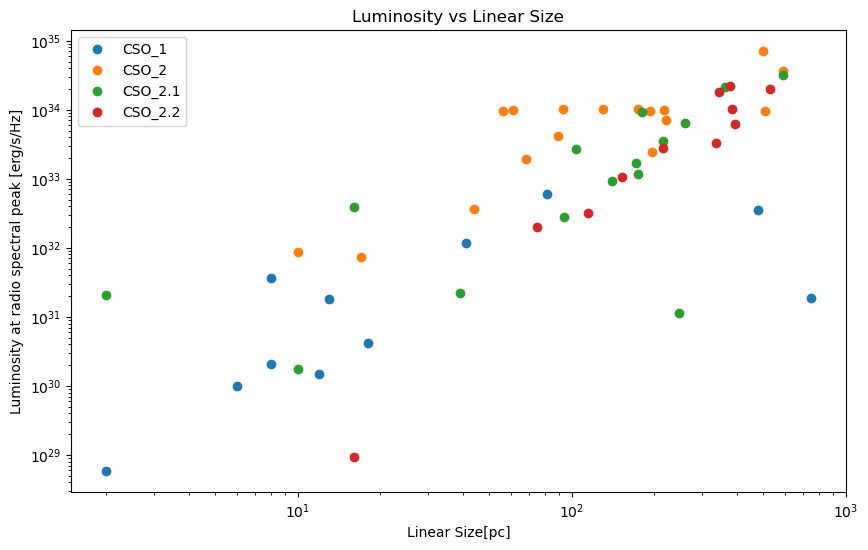

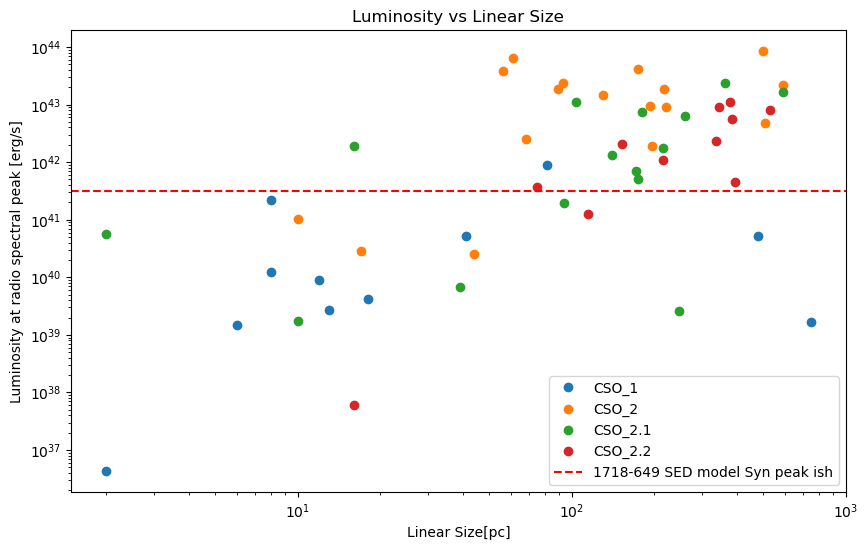

In [11]:
CSO_df = pd.DataFrame.from_dict(cso_galaxies, orient='index')
# Reset the index to make it a regular column
CSO_df.reset_index(inplace=True)

# Rename the 'index' column to 'Object Name'
CSO_df.rename(columns={'index': 'Object Name'}, inplace=True)
#print(CSO_df)
print(CSO_df.columns)
selected_columns = CSO_df[['Object Name','z', 'Turnover_freq', 'Turnover_flux_den','Ang_size','lin_size','class','major_axis_comb']].copy()


CSO_1 = selected_columns[selected_columns['class'] == 1]
CSO_2 = selected_columns[selected_columns['class'] == 2.0]
CSO_21 = selected_columns[selected_columns['class'] == 2.1]
CSO_22 = selected_columns[selected_columns['class'] == 2.2]
#print(selected_columns)
# Now, calculate the covariance matrix for the selected columns
corr_matrix = selected_columns.corr()

print(corr_matrix)


print(CSO_1)
# Combine all values into a single list

bins_z = np.linspace(0,selected_columns['z'].max(), 25)
# Plot the histogram
plt.hist(CSO_1['z'], bins=bins_z, alpha=0.5, label='CSO_1')
plt.hist(CSO_2['z'], bins=bins_z, alpha=0.5, label='CSO_2')
plt.hist(CSO_21['z'], bins=bins_z, alpha=0.5, label='CSO_2.1')
plt.hist(CSO_22['z'], bins=bins_z, alpha=0.5, label='CSO_2.2')
plt.xlabel('redshift')
plt.ylabel('Frequency')
plt.title('Histogram of Four Dictionaries')
plt.legend()

# Show the plot
plt.show()

bins_t = np.linspace(0,selected_columns['Turnover_freq'].max(), 5)
# Plot the histogram
plt.hist(CSO_1['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_1')
plt.hist(CSO_2['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2')
plt.hist(CSO_21['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2.1')
plt.hist(CSO_22['Turnover_freq'], bins=bins_t, alpha=0.5, label='CSO_2.2')
plt.xlabel('Turn_freq')
plt.ylabel('Frequency')
plt.title('Histogram of Four Dictionaries')
plt.legend()

# Show the plot
plt.show()


plt.figure(figsize=(10, 6))
plt.scatter(CSO_1['Turnover_freq'], CSO_1['Turnover_flux_den'], label='CSO_1')
plt.scatter(CSO_2['Turnover_freq'], CSO_2['Turnover_flux_den'], label='CSO_2')
plt.scatter(CSO_21['Turnover_freq'], CSO_21['Turnover_flux_den'], label='CSO_2.1')
plt.scatter(CSO_22['Turnover_freq'], CSO_22['Turnover_flux_den'], label='CSO_2.2')
plt.xlabel('Turnover Frequency')
plt.ylabel('Turnover Flux Density')
plt.title('Scatter Plot of Turnover Frequency and Turnover Flux Density')
plt.legend()
plt.show()



bins_size = np.linspace(0,selected_columns['lin_size'].max(), 20)
plt.figure(figsize=(10, 6))

#plt.hist(CSO_1['lin_size'], bins=bins_size, alpha=0.5, label='CSO_1')
plt.hist(CSO_2['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2')
#plt.hist(CSO_21['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2.1')
plt.hist(CSO_22['lin_size'], bins=bins_size, alpha=0.5, label='CSO_2.2',linestyle='dashed',histtype='step')
plt.xlabel('size')
plt.ylabel('Frequency')
plt.title('Histogram of Four Dictionaries')
plt.legend()
plt.show()



def redshift_to_distance(z):
    # Calculate comoving distance for a given redshift
    distance = cosmo.comoving_distance(z)
    
    # Convert distance to centimeters
    distance_cm = distance.to(u.cm)
    
    return distance_cm.value
convert_Jy = 1e-23

plt.figure(figsize=(10, 6))
plt.plot(CSO_1['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_1['z'])**2*CSO_1['Turnover_flux_den']*convert_Jy, 'o', label='CSO_1')
plt.plot(CSO_2['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_2['z'])**2*CSO_2['Turnover_flux_den']*convert_Jy, 'o', label='CSO_2')
plt.plot(CSO_21['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_21['z'])**2*CSO_21['Turnover_flux_den']*convert_Jy, 'o', label='CSO_2.1')
plt.plot(CSO_22['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_22['z'])**2*CSO_22['Turnover_flux_den']*convert_Jy, 'o', label='CSO_2.2')
plt.xlabel('Linear Size[pc]')
plt.ylabel('Luminosity at radio spectral peak [erg/s/Hz]')
plt.title('Luminosity vs Linear Size')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



plt.figure(figsize=(10, 6))
plt.plot(CSO_1['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_1['z'])**2*CSO_1['Turnover_flux_den']*convert_Jy*CSO_1['Turnover_freq']*1e9, 'o', label='CSO_1')
plt.plot(CSO_2['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_2['z'])**2*CSO_2['Turnover_flux_den']*convert_Jy*CSO_2['Turnover_freq']*1e9, 'o', label='CSO_2')
plt.plot(CSO_21['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_21['z'])**2*CSO_21['Turnover_flux_den']*convert_Jy*CSO_21['Turnover_freq']*1e9, 'o', label='CSO_2.1')
plt.plot(CSO_22['lin_size']*1e3, 4*np.pi*redshift_to_distance(CSO_22['z'])**2*CSO_22['Turnover_flux_den']*convert_Jy*CSO_22['Turnover_freq']*1e9, 'o', label='CSO_2.2')
#plt.plot(2, 10**41.5, 'o', label='1718-649 SED model Syn peak ish')
plt.axhline(y= 10**41.5, color='r', linestyle='--', label='1718-649 SED model Syn peak ish')
plt.xlabel('Linear Size[pc]')
plt.ylabel('Luminosity at radio spectral peak [erg/s]')
plt.title('Luminosity vs Linear Size')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



0      NaN
1      NaN
2      4.2
3      4.0
4     32.9
      ... 
75     NaN
76     NaN
77     NaN
78     NaN
79     NaN
Name: major_axis_comb, Length: 80, dtype: float64
3 3


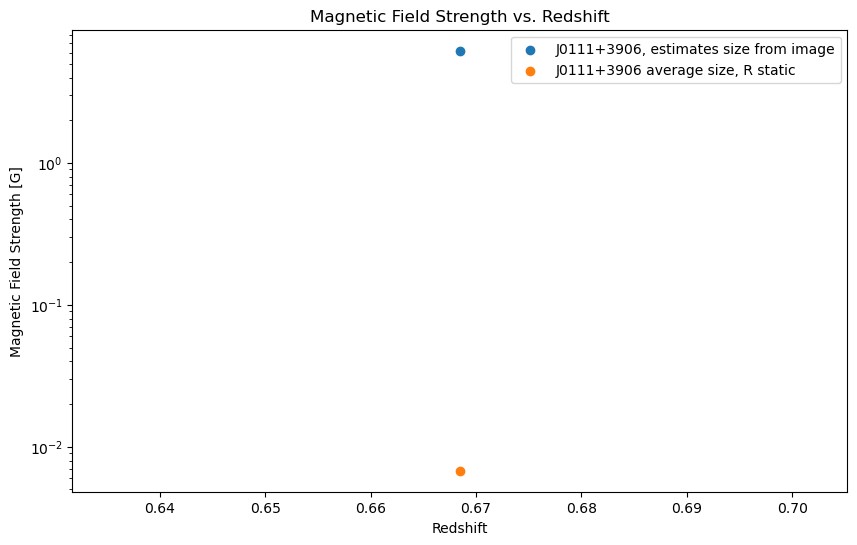

  Object Name        z  Turnover_freq  Turnover_flux_den  Ang_size  lin_size  \
2  J0029+3456  0.51700            0.8               2.00      29.1     0.180   
3  J0111+3906  0.66847            4.0               1.33       8.0     0.056   

   class  major_axis_comb  
2    2.1              4.2  
3    2.0              4.0  


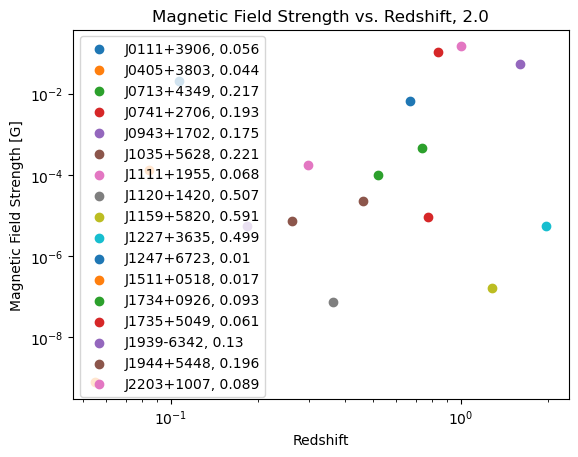

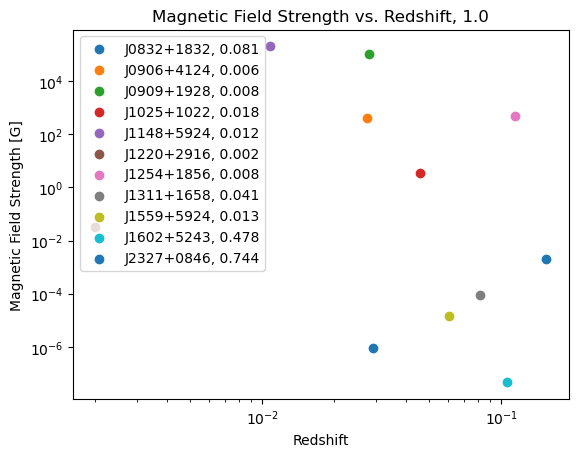

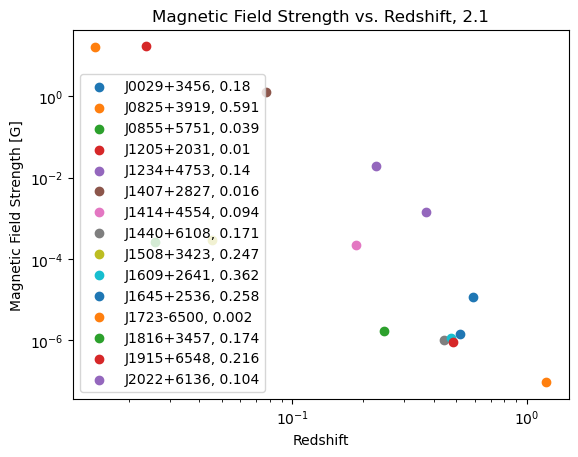

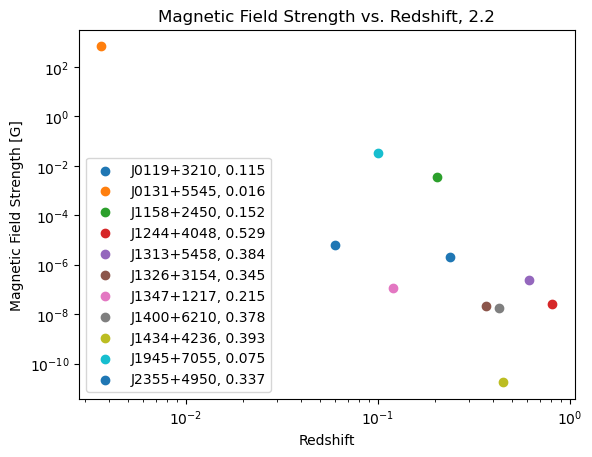

In [12]:
def calculate_B_SSA(b_alpha, S_m, d_m, nu_m, delta, z):
    """
    Calculate the magnetic field strength based on the synchrotron self-absorption (SSA) model.

    Parameters:
    b_alpha (float): The coefficient that depends on the spectral index alpha.
    S_m (float): The turnover flux density in Janskys.
    d_m (float): The source diameter in milliarcseconds.
    nu_m (float): The turnover frequency in GHz.
    delta (float): The Doppler boosting factor.
    z (float): The redshift.

    Returns:
    float: The magnetic field strength B_SSA.
    """
    #print(d_m,nu_m,S_m,b_alpha,delta,z)
    # Constants are assumed to be known and are used as placeholders here.
    # They need to be defined or imported from a module like scipy.constants.
    
    # The calculation according to the provided formula
    B_SSA = 10**-5*(b_alpha) * S_m**(-2) * d_m**(4) * nu_m**(5) * (delta / (1 + z))**(-1)
    
    return B_SSA


R = 8e18*u.cm #cm, size of blobs

#calculate average or standard angular size of emitting region
def calc_ang_size(R, z):
    return (2* R.to(u.Mpc)/cosmo.angular_diameter_distance(z).to(u.Mpc)*u.rad).to(u.mas).value


Ang_size_list_CSO1 = []
for i in range(0,len(CSO_1['z'])):
    Ang_size_list_CSO1.append(calc_ang_size(R, CSO_1['z'].iloc[i]))
Ang_size_list_CSO1 = np.array(Ang_size_list_CSO1)




Ang_size_list_CSO2 = []
for i in range(0,len(CSO_2['z'])):
    Ang_size_list_CSO2.append(calc_ang_size(R, CSO_2['z'].iloc[i]))
Ang_size_list_CSO2 = np.array(Ang_size_list_CSO2)

Ang_size_list_CSO21 = []
for i in range(0,len(CSO_21['z'])):
    Ang_size_list_CSO21.append(calc_ang_size(R, CSO_21['z'].iloc[i]))
Ang_size_list_CSO21 = np.array(Ang_size_list_CSO21)

Ang_size_list_CSO22 = []
for i in range(0,len(CSO_22['z'])):
    Ang_size_list_CSO22.append(calc_ang_size(R, CSO_22['z'].iloc[i]))
Ang_size_list_CSO22 = np.array(Ang_size_list_CSO22)




b_alpha = 2.5 

B_val = []
away = selected_columns['z'][0]
print(selected_columns['major_axis_comb'])

indexes = []
for index, row in selected_columns.iterrows():
    
    try:
      
        B_val.append(calculate_B_SSA(b_alpha, row['Turnover_flux_den'], row['major_axis_comb'], row['Turnover_freq'], 1, row['z']))
        indexes.append(index)
    except:
        continue
   

#print(selected_columns['z'][indexes[4]])




def calc_b_vals(data, Ang_size_l):
    B_vals_CSO2 = []
    for i in range(0,len(data['z'])):
        try:
            B_vals_CSO2.append(calculate_B_SSA(b_alpha, data['Turnover_flux_den'].iloc[i], Ang_size_l[i], data['Turnover_freq'].iloc[i], 1, data['z'].iloc[i]))
        except:
            continue
    return B_vals_CSO2

B_vals_CSO1 = calc_b_vals(CSO_1, Ang_size_list_CSO1)
B_vals_CSO2 = calc_b_vals(CSO_2, Ang_size_list_CSO2)
B_vals_CSO21 = calc_b_vals(CSO_21, Ang_size_list_CSO21)
B_vals_CSO22 = calc_b_vals(CSO_22, Ang_size_list_CSO22)
#print(CSO_1)



data_to_plot = selected_columns[selected_columns['Object Name']== 'J0111+3906']
index2 = selected_columns[selected_columns['Object Name']== 'J0111+3906'].index[0]
index = CSO_2[CSO_2['Object Name'] ==  'J0111+3906'].index[0]
print(index,index2)
plt.figure(figsize=(10, 6))
plt.scatter(data_to_plot['z'], B_val[index2],label = f"{selected_columns['Object Name'][index2]}, estimates size from image")
plt.scatter(CSO_2['z'].iloc[0], B_vals_CSO2[0],label = f"{CSO_2['Object Name'].iloc[0]} average size, R static")
plt.xlabel('Redshift')
plt.ylabel('Magnetic Field Strength [G]')
plt.yscale('log')
plt.title('Magnetic Field Strength vs. Redshift')
plt.legend()
plt.show()
print(selected_columns.iloc[2:4])


#plt.figure(figsize=(10, 6))
#plt.scatter(B_vals_CSO2, B_vals_CSO2,label = 'CSO_2')
def plot_CSO_Red(CSO_2, B_vals_CSO2):
    for i in range(0,len(CSO_2['z'])):
        plt.scatter(CSO_2['z'].iloc[i], B_vals_CSO2[i],label = f"{CSO_2['Object Name'].iloc[i]}, {CSO_2['lin_size'].iloc[i]}")#'CSO_1')
        #print(CSO_2['Object Name'].iloc[i],Ang_size_list_CSO2[i],B_vals_CSO2[i])
    #plt.scatter(B_vals_CSO1, B_vals_CSO1,label = CSO_1['Object Name'] )#'CSO_1')
    #plt.scatter(B_vals_CSO21, B_vals_CSO21,label = 'CSO21')
    #plt.scatter(B_vals_CSO22, B_vals_CSO22,label = 'CSO22')
    plt.xlabel('Redshift')
    plt.ylabel('Magnetic Field Strength [G]')
    plt.title(f'Magnetic Field Strength vs. Redshift, {CSO_2["class"].iloc[0]}')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()
    return

plot_CSO_Red(CSO_2, B_vals_CSO2)
plot_CSO_Red(CSO_1, B_vals_CSO1)
plot_CSO_Red(CSO_21, B_vals_CSO21)
plot_CSO_Red(CSO_22, B_vals_CSO22)